# **Estimation of CO₂ Emissions in Fault Systems at a Global Scale**

## **Introduction**

**CO₂ Flux Prediction Project — Reproducible Pipeline**

**Main objective**. To build and validate machine learning models to predict CO₂ flux (g m⁻² d⁻¹) associated with fault systems, based on geophysical, tectonic, geological, and environmental variables.

**Scope adjustment vs. previous release.** In this version, we explicitly incorporate the variable extraction process: we sample each raster and global vector at the degassing locations to obtain the training set. Furthermore, we define and apply an applicability domain (tectonic mask) to avoid extrapolations to regions without contemporaneous tectonic signal.

**Secondary objective.** To select the best model (interpretability/performance) and apply it to pixel-by-pixel prediction at 0.10°, restricted to the tectonic mask and clipped to the continent.

## **Importing libraries**

In this first code block, we import all the Python libraries used throughout the CO₂ flux modeling workflow. These packages cover file and path management, numerical and tabular data handling, geospatial processing, visualization, machine learning, and model interpretability. Centralizing all imports here helps keep the notebook organized and makes it clear which tools are required to reproduce the analysis.

In [1]:
# --- Core Python utilities ---
import os
import sys
import json
import shutil
import tempfile
import warnings
from pathlib import Path
from datetime import datetime

warnings.filterwarnings("ignore")

# --- Numerical & Data Handling ---
import numpy as np
import pandas as pd

# --- Geospatial Processing ---
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject
from rasterio.transform import from_origin
from rasterio.features import rasterize
from rasterio.windows import Window
from pyproj import CRS
import fiona
from shapely.geometry import Point, Polygon

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Machine Learning (Scikit-learn) ---
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    learning_curve
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    LabelEncoder
)
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    ElasticNetCV
)
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    StackingRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# --- Boosting Libraries ---
from xgboost import XGBRegressor

# --- Statistical Distributions (for RandomizedSearch) ---
from scipy.stats import randint, uniform

# --- Model Interpretability ---
import shap
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

print("All libraries imported successfully.")

All libraries imported successfully.


## **Load all datasets**

In this section, we load all datasets required for the CO₂ flux modeling workflow. These include point measurements of soil CO₂ degassing, verification data from previous global studies, and several geospatial layers that describe geological, tectonic, and environmental conditions. We import vector datasets such as faults, volcanoes, mineral occurrences, and continental boundaries, along with raster layers representing variables like heat flow, soil properties, vegetation cover, PGA, and bioclimatic temperature. Centralizing the data-loading step helps ensure reproducibility and provides a clear overview of all inputs used in the analysis.

In [2]:
# --- Define base paths ---
ROOT = Path(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling")
DATA = ROOT / "01_Data_Global"

# --- Load Excel tables ---
co2_points = pd.read_excel(DATA / "CO2 degassing flow - Compiled in this study" / "CO2_Flux.xlsx")

# --- Load shapefiles ---
faults = gpd.read_file(DATA / "Styron, R., & Pagani, M. (2020). The GEM global active faults database" / "gem_active_faults_harmonized.shp")
continents = gpd.read_file(DATA / "Continents World" / "CONTINENTES MUNDO LIMITE BORDE geogpsperu suyopomalia.shp")
minerals = gpd.read_file(DATA / "Schweitzer, P. N. (2019). Record quality tables for the Mineral Resources Data System" / "mrds-trim.shp")
mineralizations = gpd.read_file(DATA / "Mason, G. T., Arndt, R. E., & The Survey. (1996). Mineral Resources Data System (MRDS)" / "combined_mineralizations.shp")
volcanoes = gpd.read_file(DATA / "Global Volcanism Program. (2025). Volcanoes of the World (v. 5.2.7; 21 Feb 2025)" / "Holocene_Volcanoes.shp")

# --- Load rasters ---
awc = rxr.open_rasterio(DATA / "Fischer et al. (2008). Global Agro-Ecological Zones Assessment for Agriculture [Dataset]" / "AWC_CLASS.tif", masked=True)
soc = rxr.open_rasterio(DATA / "FAO et al. (2012). Harmonized World Soil Database (version 1.2) - Soil Organic Carbon" / "DATA_GSOCSEQ_MAP_GSOCSEQ.GSOCMAP1-5-0.tif", masked=True)
bouguer = rxr.open_rasterio(DATA / "Bonvalot et al. (2012). Global grids World Gravity Map (WGM2012)" / "WGM2012_Bouguer_ponc_2min — z.tif", masked=True)
heatflow = rxr.open_rasterio(DATA / "Lucazeau, F. (2019). Analysis and mapping of an updated terrestrial heat flow dataset" / "HF_pred_HFgrid14_img.tif", masked=True)
tree_cover = rxr.open_rasterio(DATA / "Geospatial Information Authority of Japan. (2008). Global vegetation data" / "gm_ve_v2.tif", masked=True)
ph_h2o = rxr.open_rasterio(DATA / "FAO et al. (2012). Harmonized World Soil Database (version 1.2) - pH" / "S_PH_H2O.tif", masked=True)
pga = rxr.open_rasterio(DATA / "Johnson et al. (2023). Global Earthquake Model (GEM) Seismic Hazard Map (version 2023.1.0)" / "v2023_1_pga_475_rock_3min.tif", masked=True)
soil_temp = rxr.open_rasterio(DATA / "Van den Hoogen et al. (2021). Global Soil Bioclimatic variables at 30 arcsecond resolution (Version 1)" / "SBIO1_Annual_Mean_Temperature_5_15cm.tif", masked=True)

# --- print summary ---
print("All datasets loaded successfully.")
print(f"Degassing sites: {len(co2_points)} points")
print(f"Faults: {len(faults)} features")


All datasets loaded successfully.
Degassing sites: 868 points
Faults: 13696 features


## **Define target grid and harmonize all rasters**

In this section, we define a global 0.10° grid in WGS84 and harmonize all environmental and geological datasets to this common spatial framework. First, we set the global extent, resolution, coordinate reference systems, and output folder. Then, we build helper functions to (i) reproject and resample rasters, (ii) load vector datasets with robust CRS handling, (iii) convert vector attributes into raster values or categories, and (iv) compute distance-to-feature rasters in kilometers. A configuration list (CFG) describes each variable (heat flow, Bouguer anomaly, PGA, soil properties, GLHYMPS porosity and permeability, and distances to faults, volcanoes, mineralizations, and mineral commodities) and its processing type. Finally, a loop applies the appropriate routine to each item in CFG, generating a consistent set of 0.10° WGS84 GeoTIFF layers that will be used as predictors in the CO₂ flux modeling.

In [3]:
# GLOBAL 0.10° PIPELINE 

# GLOBAL SETTINGS 
RES_DEG = 0.10
NODATA  = -9999.0
CRS_WGS84  = CRS.from_epsg(4326)
CRS_METRIC = CRS.from_epsg(3857)   # metric distances

# --- Base repo path ---
ROOT = r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling"
DATA = os.path.join(ROOT, "01_Data_Global")
OUT  = os.path.join(ROOT, "01_Data_Global", "Processed")
os.makedirs(OUT, exist_ok=True)

#  GLOBAL GRID IN WGS84 (0.10°) 
xmin, ymin, xmax, ymax = -180.0, -90.0, 180.0, 90.0
width  = int(np.ceil((xmax - xmin) / RES_DEG))   # 3600
height = int(np.ceil((ymax - ymin) / RES_DEG))   # 1800
DST_TRANSFORM = from_origin(xmin, ymax, RES_DEG, RES_DEG)

# HELPERS 

def _normalize_path(p: str) -> str:
    """Absolute path; on Windows add '\\\\?\\' prefix for long/Unicode paths."""
    p = str(Path(p).resolve())
    if os.name == "nt" and not p.startswith("\\\\?\\") and len(p) >= 240:
        p = "\\\\?\\" + p
    return p


def reproject_resample_raster(src_path, dst_path, resampling="average", categorical=False, dst_dtype=None):
    """Stream reprojection/resampling to 0.10° WGS84 grid."""
    src_path = _normalize_path(src_path)
    dst_path = _normalize_path(dst_path)
    rs = Resampling.nearest if (resampling == "nearest" or categorical) else Resampling.average
    with rasterio.open(src_path) as src:
        src_crs = src.crs or CRS_WGS84
        if dst_dtype is None:
            dst_dtype = "int16" if categorical else "float32"

        profile = {
            "driver": "GTiff",
            "height": height,
            "width":  width,
            "count": src.count,
            "crs": CRS_WGS84,
            "transform": DST_TRANSFORM,
            "dtype": dst_dtype,
            "nodata": 0 if categorical else NODATA,
            "compress": "LZW",
            "tiled": True,
            "blockxsize": 256,
            "blockysize": 256,
            "BIGTIFF": "YES",
        }
        with rasterio.open(dst_path, "w", **profile) as dst:
            for b in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, b),
                    destination=rasterio.band(dst, b),
                    src_transform=src.transform,
                    src_crs=src_crs,
                    src_nodata=src.nodata,
                    dst_transform=DST_TRANSFORM,
                    dst_crs=CRS_WGS84,
                    dst_nodata=(0 if categorical else NODATA),
                    resampling=rs
                )

def load_vector(path, layer=None, fallback_epsg=4326):
    """Read vector (SHP/GPKG/GDB or folder with SHP/GPKG). Force WGS84 if needed."""
    def _read(pth, lyr):
        if str(pth).lower().endswith(".gdb"):
            lyr = lyr or fiona.listlayers(pth)[0]
            return gpd.read_file(pth, layer=lyr)
        if os.path.isdir(pth):
            # pick first SHP/GPKG
            for pat in ("*.shp", "*.gpkg"):
                hits = list(Path(pth).glob(pat))
                if hits:
                    return gpd.read_file(str(hits[0]))
            raise FileNotFoundError(f"No vector file found in {pth}")
        return gpd.read_file(pth, layer=lyr) if lyr else gpd.read_file(pth)

    pnorm = _normalize_path(str(path))
    try:
        gdf = _read(pnorm, layer)
    except Exception as e:
        # Fallback for problematic GPKG: copy to short temp path
        if str(path).lower().endswith(".gpkg"):
            tmp = Path(tempfile.gettempdir()) / "gpkg_tmp.glhymps.gpkg"
            tmp.parent.mkdir(parents=True, exist_ok=True)
            shutil.copy2(pnorm, tmp)
            print(f"[NOTE] Copied GPKG to temp: {tmp}")
            gdf = _read(str(tmp), layer)
        else:
            raise e

    gdf = gdf[gdf.geometry.notna() & ~gdf.geometry.is_empty].copy()
    if gdf.crs is None:
        gdf = gdf.set_crs(CRS.from_epsg(fallback_epsg))
        print(f"[NOTE] No CRS -> forced EPSG:{fallback_epsg} for {Path(path).name}")
    if gdf.crs.to_epsg() != 4326:
        gdf = gdf.to_crs(4326)
    return gdf

def vector_to_raster_value(gdf, field, dst_path, all_touched=False):
    shapes = [(geom, float(val)) for geom, val in zip(gdf.geometry, gdf[field])]
    out = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        fill=NODATA,
        transform=DST_TRANSFORM,
        dtype="float32",
        all_touched=all_touched
    )
    prof = {
        "driver":"GTiff","height":height,"width":width,"count":1,
        "dtype":"float32","crs":CRS_WGS84,"transform":DST_TRANSFORM,
        "nodata":NODATA,"compress":"LZW","tiled":True,"BIGTIFF":"YES"
    }
    with rasterio.open(_normalize_path(dst_path), "w", **prof) as dst:
        dst.write(out, 1)

def vector_to_raster_categorical(gdf, field, dst_path, mapping=None, all_touched=False):
    if mapping is None:
        cats = list(dict.fromkeys(gdf[field].astype(str).tolist()))
        mapping = {c:i+1 for i,c in enumerate(cats)}  # 0 for nodata
    gdf["_cat_"] = gdf[field].astype(str).map(mapping).fillna(0).astype(int)
    shapes = [(geom, int(val)) for geom, val in zip(gdf.geometry, gdf["_cat_"])]
    out = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        fill=0,
        transform=DST_TRANSFORM,
        dtype="int16",
        all_touched=all_touched
    )
    prof = {
        "driver":"GTiff","height":height,"width":width,"count":1,
        "dtype":"int16","crs":CRS_WGS84,"transform":DST_TRANSFORM,
        "nodata":0,"compress":"LZW","tiled":True,"BIGTIFF":"YES"
    }
    with rasterio.open(_normalize_path(dst_path), "w", **prof) as dst:
        dst.write(out, 1)
    with open(dst_path.replace(".tif",".json"), "w", encoding="utf-8") as f:
        json.dump({"category_map": mapping}, f, ensure_ascii=False, indent=2)

def vector_to_distance_raster(gdf, dst_path, res_m=5000):
    """Distance (km) to lines/points in EPSG:3857 -> reproject to 0.10°."""
    gdf_m = gdf.to_crs(CRS_METRIC) if gdf.crs.to_epsg() != 3857 else gdf.copy()
    xmin_m, ymin_m, xmax_m, ymax_m = gdf_m.total_bounds
    pad = 200000.0
    xmin_m, ymin_m, xmax_m, ymax_m = xmin_m-pad, ymin_m-pad, xmax_m+pad, ymax_m+pad
    width_m  = int(np.ceil((xmax_m - xmin_m) / res_m))
    height_m = int(np.ceil((ymax_m - ymin_m) / res_m))
    transform_m = from_origin(xmin_m, ymax_m, res_m, res_m)

    shapes = [(geom, 1) for geom in gdf_m.geometry]
    mask = rasterize(shapes=shapes, out_shape=(height_m, width_m),
                     transform=transform_m, fill=0, dtype="uint8", all_touched=True)

    from scipy.ndimage import distance_transform_edt as edt
    dist_cells = edt(1 - mask)
    dist_km = (dist_cells * res_m).astype("float32") / 1000.0

    temp_3857 = dst_path.replace(".tif", "_3857.tif")
    prof_m = {"driver":"GTiff","height":height_m,"width":width_m,"count":1,
              "dtype":"float32","crs":CRS_METRIC,"transform":transform_m,
              "nodata":NODATA,"compress":"LZW","tiled":True,"BIGTIFF":"YES"}
    with rasterio.open(_normalize_path(temp_3857), "w", **prof_m) as dst:
        dst.write(dist_km, 1)

    reproject_resample_raster(temp_3857, dst_path, resampling="average", categorical=False, dst_dtype="float32")
    os.remove(_normalize_path(temp_3857))

# CONFIG

CFG = [
    # CONTINUOUS RASTERS (average)
    {"name":"HeatFlow", "kind":"raster_value",
     "src": r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\01_Data_Global\Lucazeau, F. (2019). Analysis and mapping of an updated terrestrial heat flow dataset\HF_pred_HFgrid14_img.tif",
     "resampling":"average"},

    {"name":"BouguerAnomaly", "kind":"raster_value",
     "src": r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\01_Data_Global\Bonvalot et al. (2012). Global grids World Gravity Map (WGM2012)\WGM2012_Bouguer_ponc_2min — z.tif",
     "resampling":"average"},

    {"name":"PGA", "kind":"raster_value",
     "src": r"\\?\E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\01_Data_Global\Johnson et al. (2023). Global Earthquake Model (GEM) Seismic Hazard Map (version 2023.1.0)\v2023_1_pga_475_rock_3min.tif",
     "resampling":"average"},

    {"name":"AvailableWaterStorage", "kind":"raster_value",
     "src": r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\01_Data_Global\Fischer et al. (2008). Global Agro-Ecological Zones Assessment for Agriculture [Dataset]\AWC_CLASS.tif",
     "resampling":"average"},

    {"name":"Soil_pH", "kind":"raster_value",
     "src": r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\01_Data_Global\FAO et al. (2012). Harmonized World Soil Database (version 1.2) - pH\S_PH_H2O.tif",
     "resampling":"average"},

    {"name":"SoilOrganicCarbon", "kind":"raster_value",
     "src": r"\\?\E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\01_Data_Global\FAO et al. (2012). Harmonized World Soil Database (version 1.2) - Soil Organic Carbon\DATA_GSOCSEQ_MAP_GSOCSEQ.GSOCMAP1-5-0.tif",
     "resampling":"average"},

    {"name":"TreeCover", "kind":"raster_value",
     "src": r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\01_Data_Global\Geospatial Information Authority of Japan. (2008). Global vegetation data\gm_ve_v2.tif",
     "resampling":"average"},

    {"name":"MeanAnnualSoilTemp", "kind":"raster_value",
     "src": r"\\?\E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\01_Data_Global\Van den Hoogen et al. (2021). Global Soil Bioclimatic variables at 30 arcsecond resolution (Version 1)\SBIO1_Annual_Mean_Temperature_5_15cm_wgs84.tif",
     "resampling":"average"},

    # VECTOR → VALUE
    {"name":"GLHYMPS_Porosity", "kind":"vector_value",
     "path": os.path.join(DATA, "Gleeson et al. (2014). Global Hydrogeology Maps (GLHYMPS) of permeability and porosity", "GLHYMPS", "GLHYMPS_wgs84.gpkg"),
     "layer": None, "field": "Porosity"},

    {"name":"GLHYMPS_Permeability", "kind":"vector_value",
     "path": os.path.join(DATA, "Gleeson et al. (2014). Global Hydrogeology Maps (GLHYMPS) of permeability and porosity", "GLHYMPS", "GLHYMPS_wgs84.gpkg"),
     "layer": None, "field": "Permeability_no_permafrost"},

    # DISTANCES
    {"name":"ActiveFaults_distance_km", "kind":"vector_distance",
     "path": os.path.join(DATA, "Styron, R., & Pagani, M. (2020). The GEM global active faults database"), "layer": None},

    {"name":"Volcanoes_distance_km", "kind":"vector_distance",
     "path": os.path.join(DATA, "Global Volcanism Program. (2025). Volcanoes of the World (v. 5.2.7; 21 Feb 2025)"), "layer": None},

    {"name":"Mineralizations_distance_km", "kind":"vector_distance",
     "path": os.path.join(DATA, "Mason, G. T., Arndt, R. E., & The Survey. (1996). Mineral Resources Data System (MRDS)"), "layer": None},

    {"name":"MineralCommodity_distance_km", "kind":"vector_distance",
     "path": os.path.join(DATA, "Schweitzer, P. N. (2019). Record quality tables for the Mineral Resources Data System"), "layer": None},
]

# EXECUTION

def process_item(item):
    name = item["name"]
    kind = item["kind"]
    out_tif = _normalize_path(os.path.join(OUT, f"{name}_0p10deg_WGS84.tif"))
    print(f"\n=== {name} ({kind}) ===")

    if kind in ("raster_value", "raster_categorical"):
        src = item["src"]
        if not os.path.exists(_normalize_path(src)):
            raise FileNotFoundError(f"SRC not found: {src}")
        if kind == "raster_categorical":
            reproject_resample_raster(src, out_tif, resampling="nearest", categorical=True, dst_dtype="int16")
        else:
            reproject_resample_raster(src, out_tif, resampling=item.get("resampling","average"),
                                      categorical=False, dst_dtype="float32")
        print(f"→ OK raster: {out_tif}")

    elif kind == "vector_value":
        gdf = load_vector(item["path"], layer=item.get("layer"))
        fld = item["field"]
        # Case-insensitive match
        low = {c.lower(): c for c in gdf.columns}
        fld = low.get(fld.lower(), fld)
        gdf = gdf[gdf[fld].notna()]
        vector_to_raster_value(gdf, fld, out_tif)
        print(f"→ OK vector->value: {out_tif}")

    elif kind == "vector_categorical":
        gdf = load_vector(item["path"], layer=item.get("layer"))
        fld = item["field"]
        low = {c.lower(): c for c in gdf.columns}
        fld = low.get(fld.lower(), fld)
        vector_to_raster_categorical(gdf, fld, out_tif)
        print(f"→ OK vector->categorical: {out_tif} (legend .json saved)")

    elif kind == "vector_distance":
        gdf = load_vector(item["path"], layer=item.get("layer"))
        vector_to_distance_raster(gdf, out_tif, res_m=5000)
        print(f"→ OK distance (km): {out_tif}")

    else:
        raise ValueError(f"Unsupported kind: {kind}")

if __name__ == "__main__":
    for it in CFG:
        try:
            process_item(it)
        except Exception as e:
            print(f"[WARNING] {it['name']}: {e}")

    print("\n== OUTPUT CHECK ==")
    for f in sorted(Path(OUT).glob("*_0p10deg_WGS84.tif")):
        print(" -", f.name)



=== HeatFlow (raster_value) ===
→ OK raster: E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\01_Data_Global\Processed\HeatFlow_0p10deg_WGS84.tif

=== BouguerAnomaly (raster_value) ===
→ OK raster: E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\01_Data_Global\Processed\BouguerAnomaly_0p10deg_WGS84.tif

=== PGA (raster_value) ===
→ OK raster: E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\01_Data_Global\Processed\PGA_0p10deg_WGS84.tif

=== AvailableWaterStorage (raster_value) ===
→ OK raster: E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\01_Data_Global\Processed\AvailableWaterStorage_0p10deg_WGS84.tif

=== Soil_pH (raster_value) ===
→ OK raster: E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Fl

# **Sampling of each raster at the degassing points**

In this section, we extract the value of each environmental and geological raster at the locations of the CO₂ degassing points. We first ensure that the PROJ configuration is correctly set so that coordinate transformations work in the current environment. Then we define the paths to the processed 0.10° rasters and build a dictionary that links each predictor variable name to its corresponding GeoTIFF file. A helper function loads the degassing points (with longitude, latitude, and CO₂ flux), and another function samples every raster at those coordinates, using a small neighborhood search when the exact pixel contains NoData. Finally, we assemble all sampled values into a single table, save it as a CSV file, and report the number of missing values per column. This table will be the main input dataset for the machine learning models.

In [4]:

# SAMPLE HARMONIZED RASTERS AT DEGASSING POINTS

# Set PROJ data dir 
def _ensure_proj_data_dir():
    """
    Try to locate the 'proj' folder for your environment (Conda/Miniconda on Windows) and configure PROJ_LIB and pyproj.datadir accordingly.
    """
    candidates = [
        r"c:\Users\Rolando\anaconda3\envs\tesis\Library\share\proj",
        os.path.join(sys.prefix, "Library", "share", "proj"),  
        os.path.join(sys.prefix, "share", "proj"),
    ]
    for p in candidates:
        if os.path.isdir(p):
            os.environ["PROJ_LIB"] = p
            try:
                from pyproj import datadir
                datadir.set_data_dir(p)
            except Exception:
                # If pyproj is not yet available or set_data_dir fails, we do not stop execution.
                pass
            return p
    return None

_proj_path = _ensure_proj_data_dir()

# Paths
ROOT = r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling"
PROC = os.path.join(ROOT, "01_Data_Global", "Processed")
OUT_TABLE = os.path.join(PROC, "degassing_points_features_0p10deg.csv")

# Points file
# columns: 'Longitude (x)', 'Latitude (y)', and 'Flux (gm-2d-1)'
POINTS_PATH = r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\01_Data_Global\CO2 degassing flow - Compiled in this study\CO2_Flux.xlsx"

# --- Column mapping -> harmonized raster ---
RASTERS = {
    "Bouguer_Anomaly_mGal":            os.path.join(PROC, "BouguerAnomaly_0p10deg_WGS84.tif"),
    "Heat_Flow_mW_m2":                 os.path.join(PROC, "HeatFlow_0p10deg_WGS84.tif"),
    "Annual_Mean_Temperature_C":       os.path.join(PROC, "MeanAnnualSoilTemp_0p10deg_WGS84.tif"),
    "Soil_Organic_Carbon_ton_ha":      os.path.join(PROC, "SoilOrganicCarbon_0p10deg_WGS84.tif"),
    "Soil_pH_H2O":                     os.path.join(PROC, "Soil_pH_0p10deg_WGS84.tif"),
    "faults_distance_km":              os.path.join(PROC, "ActiveFaults_distance_km_0p10deg_WGS84.tif"),
    "mineralization_distance_km":      os.path.join(PROC, "Mineralizations_distance_km_0p10deg_WGS84.tif"),
    "volcano_distance_km":             os.path.join(PROC, "Volcanoes_distance_km_0p10deg_WGS84.tif"),
    "mineral_commodity_distance_km":   os.path.join(PROC, "MineralCommodity_distance_km_0p10deg_WGS84.tif"),
    "Available_Water_Storage_mm/m":    os.path.join(PROC, "AvailableWaterStorage_0p10deg_WGS84.tif"),
    "Tree_Cover_Percentage":           os.path.join(PROC, "TreeCover_0p10deg_WGS84.tif"),
    "Porosity":                        os.path.join(PROC, "GLHYMPS_Porosity_0p10deg_WGS84.tif"),
    "Permeability_permafrost":         os.path.join(PROC, "GLHYMPS_Permeability_0p10deg_WGS84.tif"),
    "PGA_Mean":                        os.path.join(PROC, "PGA_0p10deg_WGS84.tif"),
}

# --- NoData and neighborhood ---
ZERO_IS_NODATA = {
    "geological_province_prov_type": True,
    "Lithology": True,          
}
FALLBACK_RADIUS_PX = 10         # ~1° grid is 0.10°/px

# Legends
LEGENDS = {
    "geological_province_prov_type": os.path.join(PROC, "GeologicalProvinces_0p10deg_WGS84.json"),

}

# Final order of columns
FINAL_COLUMNS = [
    'Longitude (x)', 'Latitude (y)', 'Flux (gm-2d-1)', 'Bouguer_Anomaly_mGal', 'Heat_Flow_mW_m2',
    'Annual_Mean_Temperature_C', 'Soil_Organic_Carbon_ton_ha', 'Soil_pH_H2O', 'faults_distance_km',
    'mineralization_distance_km',
    'volcano_distance_km', 'mineral_commodity_distance_km',
    'Available_Water_Storage_mm/m', 'Tree_Cover_Percentage',
    'Porosity', 'Permeability_permafrost', 'PGA_Mean'
]

# Helpers 

def _load_points(path: str) -> gpd.GeoDataFrame:
    p = Path(path)
    suf = p.suffix.lower()
    if suf in (".csv", ".txt"):
        df = pd.read_csv(p)
    elif suf in (".xlsx", ".xls"):
        df = pd.read_excel(p)
    else:
        gdf = gpd.read_file(p)
        # Do not force CRS or reproject
        if 'Longitude (x)' not in gdf.columns or 'Latitude (y)' not in gdf.columns:
            gdf['Longitude (x)'] = gdf.geometry.x
            gdf['Latitude (y)']  = gdf.geometry.y
        if 'Flux (gm-2d-1)' not in gdf.columns and 'Flux' in gdf.columns:
            gdf['Flux (gm-2d-1)'] = gdf['Flux']
        return gdf

    
    assert {'Longitude (x)', 'Latitude (y)'} <= set(df.columns), \
        "The file must contain 'Longitude (x)' and 'Latitude (y)'."
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['Longitude (x)'], df['Latitude (y)'])
    )
    if 'Flux (gm-2d-1)' not in gdf.columns:
        gdf['Flux (gm-2d-1)'] = np.nan
    return gdf

    
    assert {'Longitude (x)', 'Latitude (y)'} <= set(df.columns), \
        "El archivo debe tener 'Longitude (x)' y 'Latitude (y)'."
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['Longitude (x)'], df['Latitude (y)']),
        crs="EPSG:4326"   # mantenemos el CRS explícito ahora que PROJ está configurado
    )
    if 'Flux (gm-2d-1)' not in gdf.columns:
        gdf['Flux (gm-2d-1)'] = np.nan
    return gdf

def _safe_open(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"No raster exists: {path}")
    return rasterio.open(path)

def _load_legend(path):
    try:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        if isinstance(data, dict) and "category_map" in data:
            return data["category_map"]
        return data
    except Exception:
        return None

def _sample_with_fallback(ds, x, y, zero_is_nodata=False, r_max=3):
    """
    Returns the value of band 1 at (x,y). If NODATA, searches in an increasing neighborhood (square windows) up to r_max pixels using the nearest valid neighbor.
    If NODATA, returns the nearest valid neighbor.
    """
    row, col = ds.index(x, y)

    nod = ds.nodata
    def _is_nodata(v):
        if v is None:
            return True
        if np.isnan(v):
            return True
        if nod is not None and v == nod:
            return True
        if zero_is_nodata and v == 0:
            return True
        return False

    v0 = ds.read(1, window=((row, row+1), (col, col+1)),
                 boundless=True, fill_value=np.nan)[0, 0]
    if not _is_nodata(float(v0)):
        return float(v0)

    for r in range(1, r_max + 1):
        win = ((row - r, row + r + 1), (col - r, col + r + 1))
        arr = ds.read(1, window=win, boundless=True, fill_value=np.nan)

        valid = np.isfinite(arr)
        if nod is not None:
            valid &= (arr != nod)
        if zero_is_nodata:
            valid &= (arr != 0)

        if not np.any(valid):
            continue

        rr, cc = np.indices(arr.shape, dtype=np.float32)
        d2 = (rr - r) * (rr - r) + (cc - r) * (cc - r)
        d2 = np.where(valid, d2, np.inf)

        idx = np.unravel_index(np.argmin(d2), d2.shape)
        val = float(arr[idx])
        if not _is_nodata(val):
            return val

    return np.nan

def sample_rasters_for_points(points_gdf: gpd.GeoDataFrame) -> pd.DataFrame:
    out = points_gdf.copy()
    if 'Flux (gm-2d-1)' not in out.columns:
        out['Flux (gm-2d-1)'] = np.nan

    xy = list(zip(out['Longitude (x)'].values, out['Latitude (y)'].values))

    for col, tif in RASTERS.items():
        zero_nd = ZERO_IS_NODATA.get(col, False)
        vals = []
        with _safe_open(tif) as ds:
            for (x, y) in xy:
                v = _sample_with_fallback(ds, x, y, zero_is_nodata=zero_nd, r_max=FALLBACK_RADIUS_PX)
                vals.append(v)
        out[col] = np.array(vals, dtype=float)

        if col in LEGENDS and os.path.exists(LEGENDS[col]):
            legend = _load_legend(LEGENDS[col])
            if legend:
                if all(isinstance(v, int) for v in legend.values()):
                    inv = {int(v): k for k, v in legend.items()}
                else:
                    inv = {int(k): v for k, v in legend.items()}
                out[col] = pd.Series(out[col]).round().astype('Int64').map(inv).astype('object')

    for c in FINAL_COLUMNS:
        if c not in out.columns:
            out[c] = np.nan
    out = out[FINAL_COLUMNS]

    return pd.DataFrame(out.drop(columns="geometry", errors="ignore"))

# Execution 

pts = _load_points(POINTS_PATH)
df = sample_rasters_for_points(pts)

out_csv = os.path.join(PROC, "degassing_points_features_0p10deg.csv")
df.to_csv(out_csv, index=False)
print(f"Final file saved in: {out_csv}")

missing_values = df.isnull().sum().sort_values(ascending=False)
print("\nMissing values per column:\n", missing_values)


Final file saved in: E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\01_Data_Global\Processed\degassing_points_features_0p10deg.csv

Missing values per column:
 Annual_Mean_Temperature_C        10
Porosity                          2
Soil_pH_H2O                       2
PGA_Mean                          2
Available_Water_Storage_mm/m      2
Permeability_permafrost           2
Longitude (x)                     0
Latitude (y)                      0
Flux (gm-2d-1)                    0
faults_distance_km                0
Soil_Organic_Carbon_ton_ha        0
Bouguer_Anomaly_mGal              0
Heat_Flow_mW_m2                   0
mineral_commodity_distance_km     0
volcano_distance_km               0
mineralization_distance_km        0
Tree_Cover_Percentage             0
dtype: int64


## **Data Exploration and Preprocessing**

In this section, we perform an initial exploration of the dataset to understand its structure, quality, and readiness for machine-learning modeling. We begin by loading the table of degassing points and examining its dimensions, column names, and a preview of the first rows. Then, we inspect data types, non-null counts, and obtain descriptive statistics for all numerical variables, which helps identify potential inconsistencies or unexpected values. Finally, we evaluate the amount of missing data in each feature and apply a simple imputation strategy—using the median for numerical variables—to ensure that the dataset is complete and suitable for downstream modeling. This exploratory step provides a clean and reliable foundation for the analysis that follows.

### Dimensions and Overview

In [2]:
df = pd.read_csv(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\01_Data_Global\Processed\degassing_points_features_0p10deg.csv")


# Shape of the dataset
print("Dataset dimensions:", df.shape)

# Column names
print("Column names:", df.columns.tolist())

# Quick glance at the first few rows
df.head()

Dataset dimensions: (868, 17)
Column names: ['Longitude (x)', 'Latitude (y)', 'Flux (gm-2d-1)', 'Bouguer_Anomaly_mGal', 'Heat_Flow_mW_m2', 'Annual_Mean_Temperature_C', 'Soil_Organic_Carbon_ton_ha', 'Soil_pH_H2O', 'faults_distance_km', 'mineralization_distance_km', 'volcano_distance_km', 'mineral_commodity_distance_km', 'Available_Water_Storage_mm/m', 'Tree_Cover_Percentage', 'Porosity', 'Permeability_permafrost', 'PGA_Mean']


,Longitude (x),Latitude (y),Flux (gm-2d-1),Bouguer_Anomaly_mGal,Heat_Flow_mW_m2,Annual_Mean_Temperature_C,Soil_Organic_Carbon_ton_ha,Soil_pH_H2O,faults_distance_km,mineralization_distance_km,volcano_distance_km,mineral_commodity_distance_km,Available_Water_Storage_mm/m,Tree_Cover_Percentage,Porosity,Permeability_permafrost,PGA_Mean
0,30.950000,62.766667,1.882126,90.017159,34.279999,3.247222,106.661438,4.9,3183.453857,137.112274,3708.472900,129.960510,4.0,71.003471,0.01,-14.1,0.000000
1,23.733333,61.450000,2.681888,91.695824,44.770000,4.224306,57.500488,5.0,2600.476318,46.841461,2934.034912,70.439674,5.0,69.480904,0.01,-14.1,0.000000
2,25.366667,64.933333,2.585910,64.170044,41.459999,3.540972,58.553421,4.6,3296.525635,138.861176,3736.008789,128.453186,1.0,106.682289,0.19,-15.2,0.010564
3,-43.583300,-21.550000,1.736000,88.826988,42.650002,19.288889,52.972733,4.8,2156.988525,71.202858,2570.860596,31.919378,1.0,39.256943,0.01,-13.0,0.000000
4,160.616000,56.015000,26.640000,116.937355,68.279999,-14.299306,13.390638,5.9,64.673790,199.310501,5.624388,275.389801,4.0,0.000000,0.09,-12.5,0.255719


**Analysis:**

- We examine the number of rows and columns to understand the size of the dataset.
- The column list gives us an overview of the available features, including any target variable (Flux (gm-2d-1)).
- df.head() provides a preview of how data is structured.

### General Information and Data Types

In [3]:
# Inspect data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Longitude (x)                  868 non-null    float64
 1   Latitude (y)                   868 non-null    float64
 2   Flux (gm-2d-1)                 868 non-null    float64
 3   Bouguer_Anomaly_mGal           868 non-null    float64
 4   Heat_Flow_mW_m2                868 non-null    float64
 5   Annual_Mean_Temperature_C      858 non-null    float64
 6   Soil_Organic_Carbon_ton_ha     868 non-null    float64
 7   Soil_pH_H2O                    866 non-null    float64
 8   faults_distance_km             868 non-null    float64
 9   mineralization_distance_km     868 non-null    float64
 10  volcano_distance_km            868 non-null    float64
 11  mineral_commodity_distance_km  868 non-null    float64
 12  Available_Water_Storage_mm/m   866 non-null    flo

In [4]:
# Statistical summary of numerical variables
df.describe()

,Longitude (x),Latitude (y),Flux (gm-2d-1),Bouguer_Anomaly_mGal,Heat_Flow_mW_m2,Annual_Mean_Temperature_C,Soil_Organic_Carbon_ton_ha,Soil_pH_H2O,faults_distance_km,mineralization_distance_km,volcano_distance_km,mineral_commodity_distance_km,Available_Water_Storage_mm/m,Tree_Cover_Percentage,Porosity,Permeability_permafrost,PGA_Mean
count,868.000000,868.000000,8.680000e+02,868.000000,868.000000,858.000000,868.000000,866.000000,868.000000,868.000000,868.000000,868.000000,866.000000,868.000000,866.000000,866.000000,866.000000
mean,0.273645,29.072702,5.314485e+04,49.051954,92.588066,12.936807,58.657152,6.438443,198.202518,103.735014,373.686519,68.747578,2.976328,56.684460,0.116420,-13.083718,0.287875
std,81.793070,20.879151,5.106588e+05,159.190200,36.960655,6.302177,43.233173,0.934473,626.607810,146.276352,709.012669,107.285269,1.939665,60.298226,0.069401,1.056825,0.165971
min,-178.791000,-39.420000,2.714795e-01,-483.398560,33.369999,-14.299306,2.000000,4.200000,0.000000,3.693204,4.002849,0.611598,1.000000,0.000000,0.010000,-16.500000,0.000000
25%,-86.327000,19.597514,1.867000e+01,-26.517450,67.699997,6.767188,35.904617,5.900000,4.365637,36.807541,9.521265,24.698423,1.000000,17.432291,0.090000,-14.075000,0.189798
50%,14.140000,36.405000,5.517000e+01,84.443672,78.500000,13.259375,51.506861,6.400000,18.918455,61.251490,78.569725,32.832039,3.000000,42.901909,0.090000,-12.500000,0.245774
75%,36.404355,40.820000,2.808219e+02,141.269119,108.831251,18.997223,66.181652,7.000000,45.547172,125.052063,349.725632,94.289017,5.000000,55.069443,0.190000,-12.500000,0.385888
max,177.180000,64.933333,5.651402e+06,389.462585,239.164993,27.416666,338.642700,9.900000,3532.620117,2142.479980,4093.501709,1751.650024,7.000000,254.000000,0.280000,-10.900000,1.001232


**Analysis:**

- df.info() shows the count of non-null values and the data type (object, float, int, etc.) for each column.
- df.describe() gives us quick descriptive statistics (mean, std, min, quartiles, max) for numerical features.
- This step helps to identify data type mismatches, missing values, or outliers in the numerical distribution.

### Missing Data Analysis

In [5]:
# Percentage of missing values
missing_percentage = (df.isnull().sum() / len(df)) * 100
print("\nPercentage of missing values:\n", missing_percentage)


Percentage of missing values:
 Longitude (x)                    0.000000
Latitude (y)                     0.000000
Flux (gm-2d-1)                   0.000000
Bouguer_Anomaly_mGal             0.000000
Heat_Flow_mW_m2                  0.000000
Annual_Mean_Temperature_C        1.152074
Soil_Organic_Carbon_ton_ha       0.000000
Soil_pH_H2O                      0.230415
faults_distance_km               0.000000
mineralization_distance_km       0.000000
volcano_distance_km              0.000000
mineral_commodity_distance_km    0.000000
Available_Water_Storage_mm/m     0.230415
Tree_Cover_Percentage            0.000000
Porosity                         0.230415
Permeability_permafrost          0.230415
PGA_Mean                         0.230415
dtype: float64


- We first count how many missing (null) entries there are in each column.
- Then we calculate the percentage of missing values relative to the total number of rows.
- This helps us decide whether to drop columns/rows or perform imputation (depending on the extent of missingness and the importance of each feature).

#### Imputing Missing Values

Rationale for Median Imputation: The median is a robust measure of central tendency, less influenced by extreme outliers compared to the mean. When data are skewed or contain significant outliers, the median often provides a more representative midpoint. By imputing missing values with the median, we reduce the risk of introducing biases caused by extreme values, thereby potentially yielding more stable and reliable models.

In [6]:
# Use SimpleImputer with 'median' strategy to fill missing numeric values
from sklearn.impute import SimpleImputer

# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Create the imputer object
imputer = SimpleImputer(strategy='median')

# Apply imputation to numeric columns
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

**Outcome:**

- All numeric columns with missing values are now filled using the median of each respective column.
- This step helps ensure we retain as many data points as possible without discarding entire rows, which could reduce the dataset size unnecessarily.

## **Exploratory Data Analysis**

In this section, we explore the statistical behavior of the CO₂ degassing flux and examine how it relates to the environmental and geological predictors. We begin by visualizing the raw flux distribution, which is strongly right-skewed due to the presence of very high emission values. To stabilize the variance and make the target more suitable for machine-learning models, we apply a logarithmic transformation and visualize the resulting distribution, which becomes more balanced and interpretable. We also categorize the log-transformed flux into three intuitive classes, Low, Moderate, and High, to better understand how degassing intensity is represented across the dataset. Finally, we explore each predictor variable using stacked bar charts, which not only summarize their frequency distribution but also show how the flux categories are distributed across different ranges of each feature. This exploratory analysis provides important insights into the structure of the data and helps guide subsequent modeling decisions.

### Distribution of the Target Variable

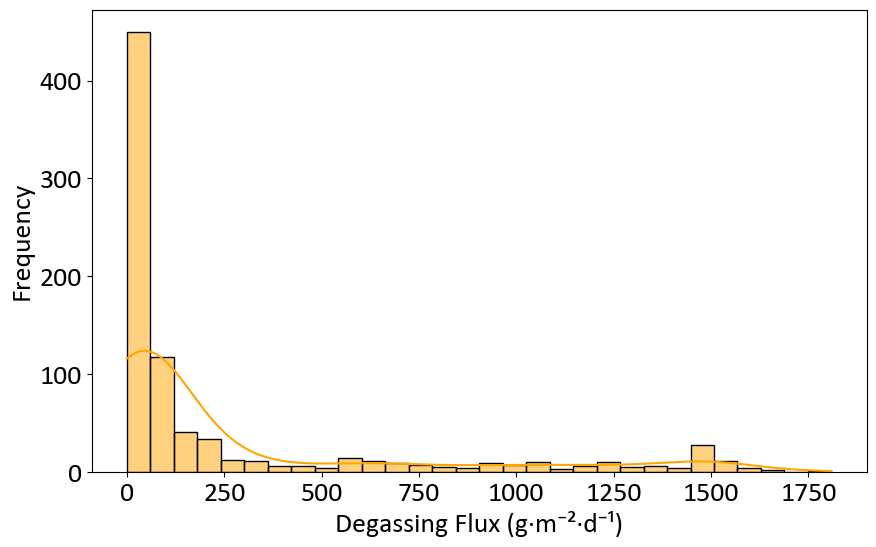

In [7]:
# Plot the original target distribution
df = df[df["Flux (gm-2d-1)"] <= 2000]
plt.rcParams["font.family"] = "Calibri"
plt.rcParams["font.size"] = 20
plt.figure(figsize=(10, 6))
sns.histplot(df['Flux (gm-2d-1)'], kde=True, bins=30, color="orange")
# plt.title("Distribution of CO₂ Degassing Flux")  
plt.xlabel("Degassing Flux (g·m⁻²·d⁻¹)")
plt.ylabel("Frequency")
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_3a.png", dpi=300, bbox_inches="tight")
plt.show()

**Data Exclusion Rationale:**

- After exploratory checks, we determined that records with very high CO₂ flux (above 2000 gm⁻² d⁻¹) were sparse and lacked sufficient coverage in the dataset.
- Keeping extreme outliers with little to no complementary data could adversely affect the modeling process.

### Logarithmic Transformation
#### Why Log Transform?

- The flux values are strictly positive, making them ideal candidates for a log transform.
- A log transform can reduce right-skewness and help many algorithms better capture the majority of the data distribution.
- It also diminishes the influence of extreme values, potentially improving regression performance and stabilizing variance.

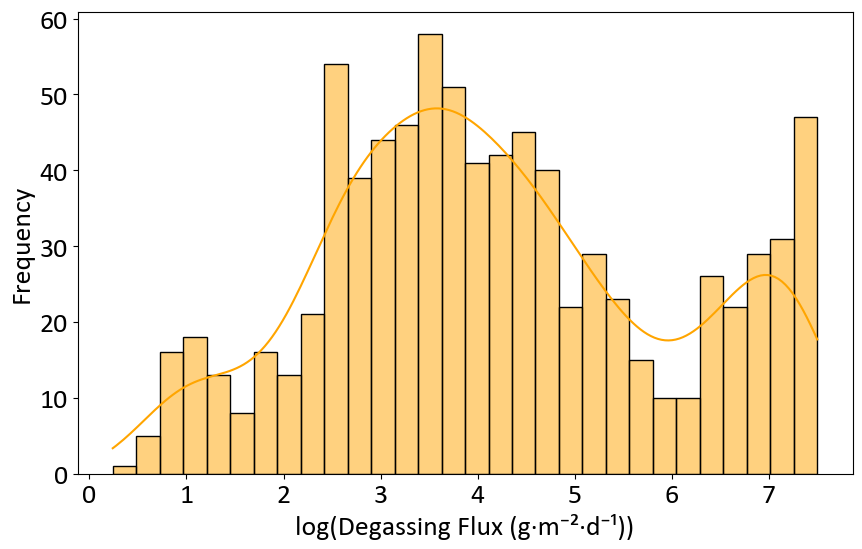

In [8]:
# Create a new column with log-transformed Flux
df['Flux_log'] = np.log(df['Flux (gm-2d-1)'] + 1)  # +1 to avoid log(0)

# Plot the log-transformed target distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Flux_log'], kde=True, bins=30, color="orange")
# plt.title("Logarithmic Distribution of CO₂ Degassing Flux") 
plt.xlabel("log(Degassing Flux (g·m⁻²·d⁻¹))")
plt.ylabel("Frequency")
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_3b.png", dpi=300, bbox_inches="tight")
plt.show()

**Observations on Log-Transformed Distribution:**

- The distribution is now much less skewed.
Most values cluster around a central range, with fewer extreme tails.
- This transformation should help many machine learning models learn patterns more effectively and reduce the undue influence of outliers.
- We should still stay alert for possible bimodality or multimodal tendencies, which might suggest subpopulations in the data (e.g., different geological contexts).


### Categorizing the Log-Transformed Flux

In this case, the logarithm-transformed flow is segmented into qualitative bins (e.g., Low, Moderate, High) based on domain-specific thresholds, in order to perform an exploratory analysis of these ranges based on the explanatory variables.

In [9]:
# Create log-based categories
df['Flux_log_range'] = pd.cut(
    df['Flux_log'],
    bins=[0, 2, 5, np.inf],  #
    labels=['Low', 'Moderate', 'High']
)


print(df['Flux_log_range'].value_counts())

Flux_log_range
Moderate    502
High        252
Low          81
Name: count, dtype: int64


### Geophysical and Geothermal Variables


These variables relate to the Earth's internal properties, heat transfer, and geophysical anomalies that may be tied to degassing processes:

- **Heat_Flow_mW_m2:** Surface heat flux (mW/m²), directly related to the internal energy and geothermal activity of the Earth.
- **Bouguer_Anomaly_mGal:** A gravity anomaly (mGal) that helps identify anomalous density distributions in the subsurface, potentially linked to fluid pathways or thermal anomalies.


#### Bouguer Anomaly (mGal)

<Figure size 1200x600 with 0 Axes>

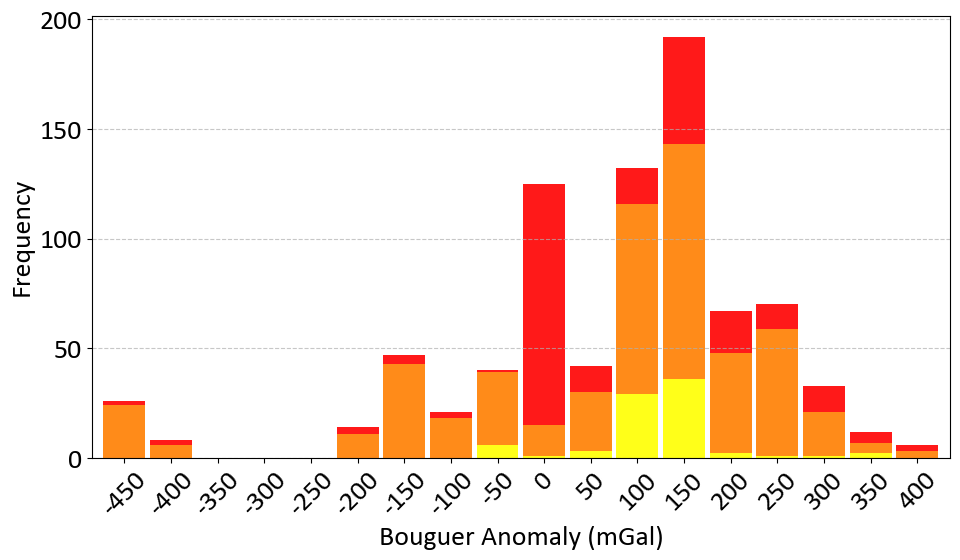

In [10]:
def plot_bouguer_anomaly_distribution(df):
    """Generates a histogram of the Bouguer anomaly with 50 mGal intervals,
    showing the proportion of CO₂ flux without the descriptive statistics box."""

    # Define data for the 'Bouguer_Anomaly_mGal' variable
    bouguer_anomaly = df['Bouguer_Anomaly_mGal']

    # Define histogram bins for Bouguer anomaly
    bins_anomaly = np.arange(-500, 450, 50)

    # Group data by CO₂ flux and Bouguer anomaly
    grouped_data = df.groupby(pd.cut(df["Bouguer_Anomaly_mGal"], bins=bins_anomaly))["Flux_log_range"].value_counts().unstack().fillna(0)

    # Extract only final interval values for the X-axis
    tick_labels = [str(int(b)) for b in bins_anomaly[1:]]
    plt.rcParams["font.family"] = "Calibri"  
    plt.rcParams["font.size"] = 20 
    
    # Create figure
    plt.figure(figsize=(12, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration
    plt.xlabel("Bouguer Anomaly (mGal)")
    plt.ylabel("Frequency")
    #plt.title("Bouguer Anomaly with Flux Proportion")  
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust X-axis labels to show only final interval values
    ax.set_xticklabels(tick_labels, rotation=45)
    
    # Remove legend
    ax.get_legend().remove()
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")  
    
    plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_4a.png", dpi=300, bbox_inches="tight")
    
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_bouguer_anomaly_distribution(df)

**Observations:**

- The Bouguer anomaly is grouped in 50 mGal intervals, capturing both negative (potentially lower density) and positive (higher density) anomaly regions.
- Large negative anomalies may indicate zones of crustal thinning or significant fluid presence that could enable CO₂ flow.
- By stacking the flux categories, we can explore if certain anomaly ranges align with higher CO₂ flux occurrences.

#### Heat Flow (mW/m²)

<Figure size 1200x600 with 0 Axes>

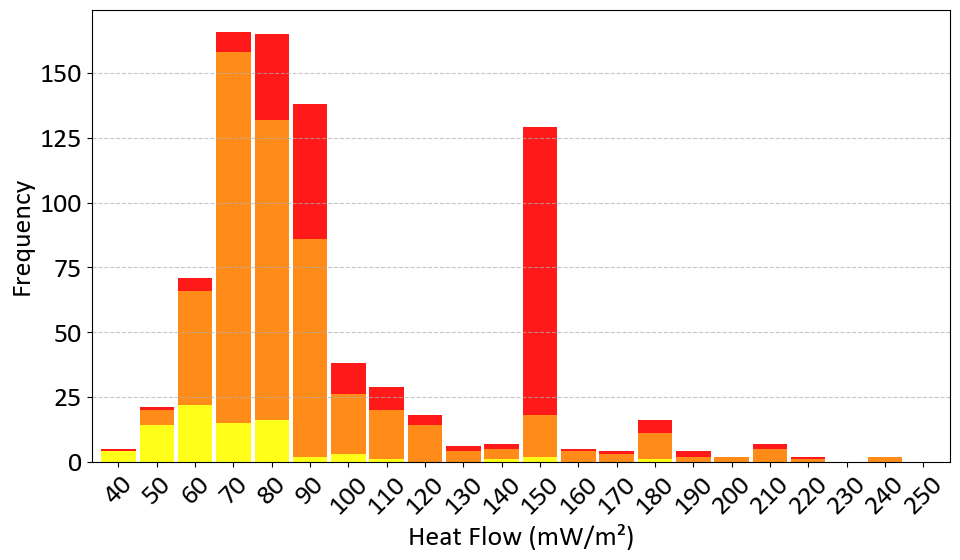

In [11]:
def plot_heat_flow_distribution(df):
    """Generates a heat flow histogram with 10 mW/m² intervals,
    showing the proportion of CO₂ flux without the descriptive statistics box."""

    # Filter values within the range of interest
    heat_flow_values = df["Heat_Flow_mW_m2"]
    
    # Define histogram bins for heat flow
    bins_heat_flow = np.arange(30, 260, 10)

    # Group data by CO₂ flux and heat flow
    grouped_data = df.groupby(pd.cut(df["Heat_Flow_mW_m2"], bins=bins_heat_flow))["Flux_log_range"].value_counts().unstack().fillna(0)

    # Extract only final interval values for the X-axis
    tick_labels = [str(int(b)) for b in bins_heat_flow[1:]]
    
    # Configure graph font
    plt.rcParams["font.family"] = "Calibri" 
    plt.rcParams["font.size"] = 20  
    
    # Create figure
    plt.figure(figsize=(12, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration
    plt.xlabel("Heat Flow (mW/m²)")
    plt.ylabel("Frequency")
    #plt.title("Heat Flow with Flux Proportion")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Adjust X-axis labels to show only final interval values
    ax.set_xticklabels(tick_labels, rotation=0)
    plt.xticks(rotation=45)
 
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.get_legend().remove()
    plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_4b.png", dpi=300, bbox_inches="tight")
    
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_heat_flow_distribution(df)

**Observations:**
- This plot shows the distribution of samples across discrete heat-flow bins (30 to 250 mW/m²).
- Each bar is subdivided into **Low, Moderate, or High** CO₂ flux categories (based on `Flux_log_range`).
- Higher heat flow could indicate more intense geothermal activity, potentially correlated with CO₂ emissions.

### Tectonic and Structural Variables

In this section, we explore variables related to fault proximity, fault type, geological provinces, mineralization distance, volcano distance, and other tectonic indicators. These features may have a direct influence on CO₂ flux emissions through subsurface pathways and geodynamic settings.


**Variables:**

- **faults_distance_km**: Distance to the nearest fault (km).     
- **mineralization_distance_km**: Distance to mineralized areas (often associated with tectonic structures).  
- **volcano_distance_km**: Distance to the nearest volcano, a proxy for volcanic/tectonic activity.  
- **PGA_Mean**: Mean Peak Ground Acceleration, an indicator often related to seismic hazard and tectonic activity.  
- **mineral_commodity_distance_km**: Distance to known mineral resources, which can be tied to certain tectonic or hydrothermal processes.

#### Distance to Faults

<Figure size 1000x600 with 0 Axes>

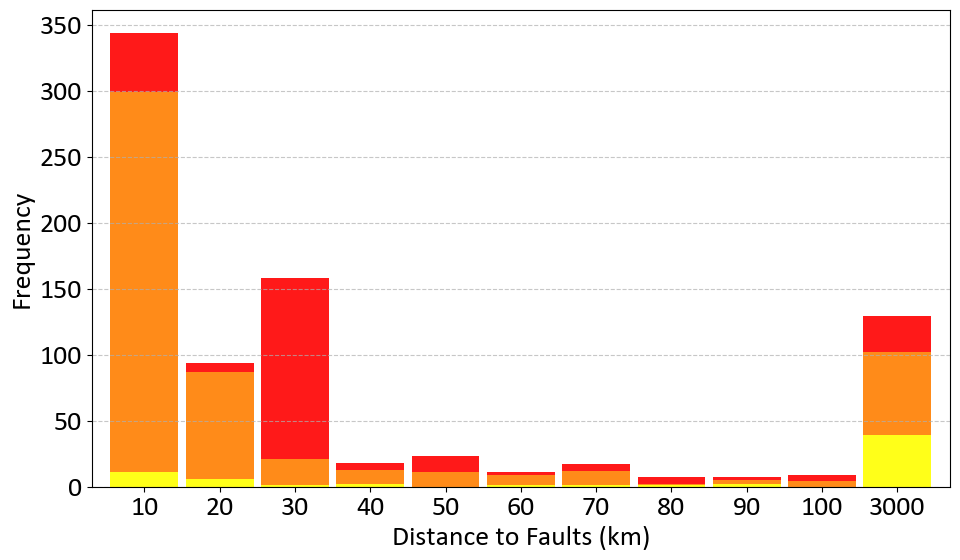

In [12]:
def plot_faults_distance_histogram(df):
    """
    Generates a stacked bar chart showing the distribution of distance to active faults
    with the proportion of CO₂ flux in each category, using vertical bars.
    """

    
    bins = list(np.arange(0, 110, 10)) + [3000] 
    labels = [f"{int(bins[i+1])}" for i in range(len(bins) - 1)]  

    # Categorize fault distance
    df["Fault_Distance_Categories"] = pd.cut(
        df["faults_distance_km"], 
        bins=bins, 
        labels=labels, 
        include_lowest=True, 
        ordered=True
    )

    # Group data by CO₂ flux category
    grouped_data = df.groupby("Fault_Distance_Categories")["Flux_log_range"].value_counts().unstack().fillna(0)
    grouped_data = grouped_data.reindex(labels)  # Ensure numerical order

    # Configure font
    plt.rcParams["font.family"] = "Calibri"
    plt.rcParams["font.size"] = 20

    # Plot stacked bar chart
    plt.figure(figsize=(10, 6))
    orig_map = plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, cmap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Configure axes and labels
    plt.xlabel("Distance to Faults (km)")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=0)
    ax.get_legend().remove()
    plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_5a.png", dpi=300, bbox_inches="tight")
    plt.tight_layout()
    plt.show()

# Run the function
plot_faults_distance_histogram(df)

**Observations:**
- The stacked bars show how many samples belong to each fault-distance bin, further subdivided by CO₂ flux categories (Low, Moderate, High).
- We might expect closer distances to faults to have higher flux if active faulting facilitates degassing.

#### Peak Ground Acceleration (PGA)

<Figure size 1000x600 with 0 Axes>

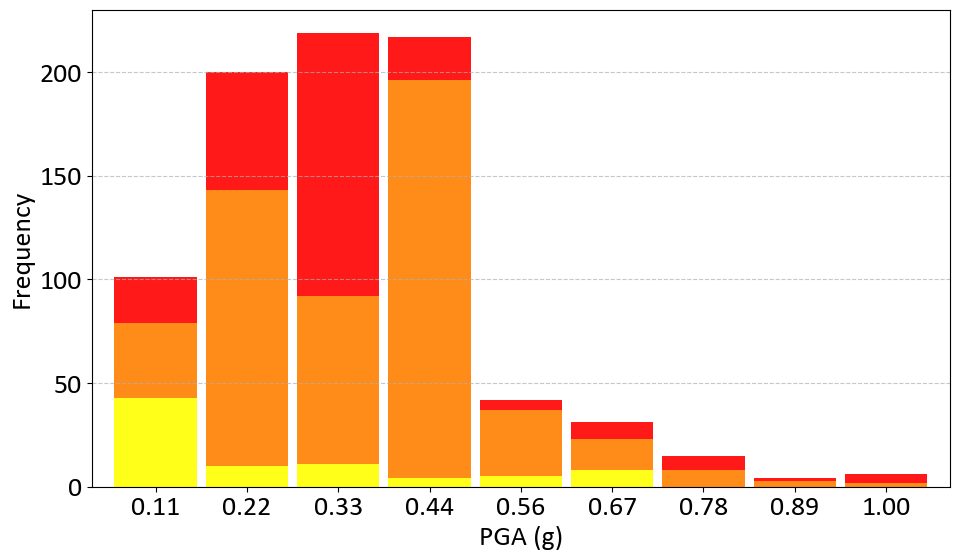

In [13]:
def plot_pga_histogram(df):
    """Generates a stacked bar chart showing the distribution of PGA
    with the proportion of CO₂ flux in each category, maintaining numerical order and swapping axes."""

    # Define bins for PGA
    bins = np.linspace(df["PGA_Mean"].min(), df["PGA_Mean"].max(), num=10)
    labels = [f"{bins[i+1]:.2f}" for i in range(len(bins)-1)]  # Show only the final interval value

    # Categorize PGA into defined bins
    df["PGA_Category"] = pd.cut(df["PGA_Mean"], bins=bins, labels=labels, include_lowest=True)

    # Group data by CO₂ flux and PGA category
    grouped_data = df.groupby("PGA_Category")["Flux_log_range"].value_counts().unstack().fillna(0)

    # Maintain defined order of intervals
    grouped_data = grouped_data.reindex(labels)

    # Create figure with vertical bar chart 
    plt.figure(figsize=(10, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration with swapped axes:
    plt.xlabel("PGA (g)")  
    plt.ylabel("Frequency")  
    #plt.title("PGA with Flux Proportion")
    plt.grid(axis='y', linestyle='--', alpha=0.7)  
    plt.xticks(rotation=0)
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.get_legend().remove()
    plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_5c.png", dpi=300, bbox_inches="tight")
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_pga_histogram(df)

**Observations:**
- Higher PGA could suggest more seismically active areas, which might correlate with active degassing pathways.
- This visualization checks if certain PGA ranges correspond to higher or lower flux categories.

#### Mineral Commodity Distance

<Figure size 1000x600 with 0 Axes>

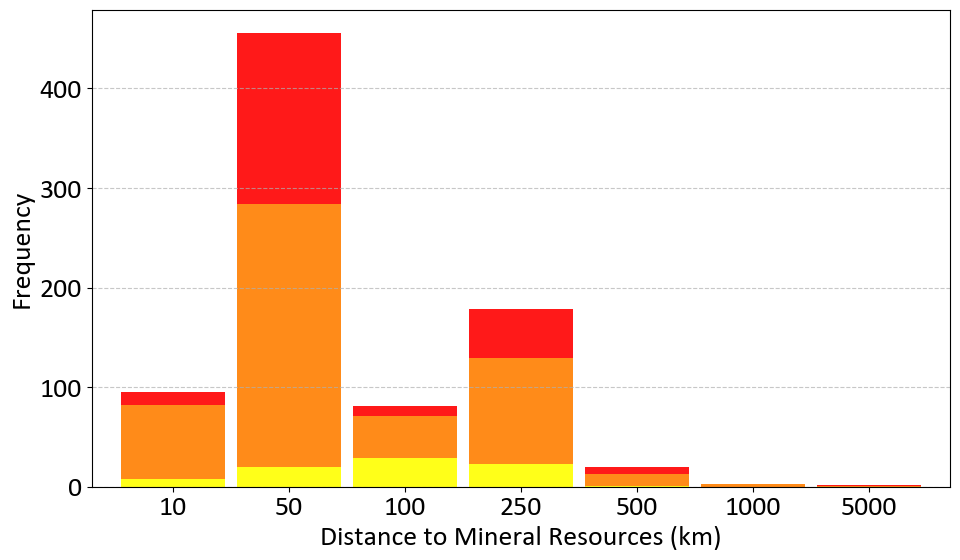

In [14]:
def plot_mineral_commodity_distance_histogram(df):
    """Generates a stacked bar chart showing the distribution of distance to mineral resources
    with the proportion of CO₂ flux in each category."""

    # Define bins for distance to mineral resources
    bins = [0, 10, 50, 100, 250, 500, 1000, 5000]
    labels = [f"{int(bins[i+1])}" for i in range(len(bins)-1)]  

    # Categorize distance to mineral resources into defined bins
    df["Mineral_Commodity_Distance_Categories"] = pd.cut(
        df["mineral_commodity_distance_km"], 
        bins=bins, 
        labels=labels, 
        include_lowest=True, 
        ordered=True
    )

    # Group data by CO₂ flux and mineral resource distance category
    grouped_data = df.groupby("Mineral_Commodity_Distance_Categories")["Flux_log_range"].value_counts().unstack().fillna(0)

    # Maintain numerical order of categories
    grouped_data = grouped_data.reindex(labels)

    # Create figure with stacked bar chart
    plt.figure(figsize=(10, 6))
    orig_map = plt.cm.get_cmap('autumn')
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration
    plt.xlabel("Distance to Mineral Resources (km)")
    plt.ylabel("Frequency")
    #plt.title("Distance to Mineral Resources with CO₂ Flux Proportion")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=0)
    
    # Adjust legend
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.get_legend().remove()
    # Save the image
    plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_5d.png", dpi=300, bbox_inches="tight")

    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset if available
plot_mineral_commodity_distance_histogram(df)

**Observations:**
- Mineral resources areas sometimes coincide with structural weaknesses or hydrothermal systems that can facilitate CO₂ release.
- This chart helps us see if proximity to mineralization resource correlates with higher flux categories.

#### Distance to Mineralizations

<Figure size 1000x600 with 0 Axes>

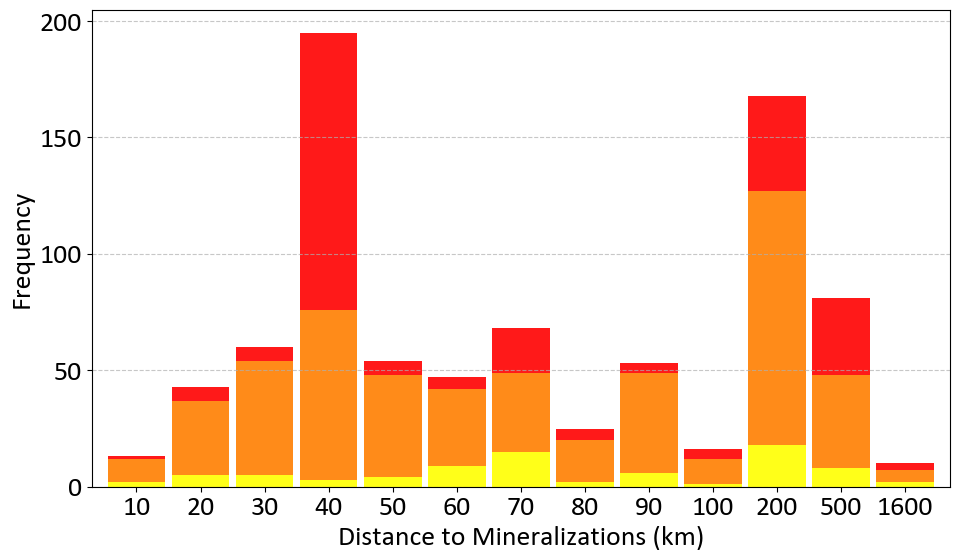

In [15]:
def plot_mineralization_distance_histogram(df):
    """Generates a stacked bar chart showing the distribution of distance to mineralizations
    with the proportion of CO₂ flux in each category, with swapped axes."""

    # Define bins for distance to mineralizations
    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500, 1600]
    labels = [f"{int(bins[i+1])}" for i in range(len(bins)-1)]  

    # Categorize distance to mineralizations into defined bins
    df["Mineralization_Distance_Categories"] = pd.cut(
        df["mineralization_distance_km"], 
        bins=bins, 
        labels=labels, 
        include_lowest=True, 
        ordered=True
    )

    # Group data by CO₂ flux and mineralization distance category
    grouped_data = df.groupby("Mineralization_Distance_Categories")["Flux_log_range"].value_counts().unstack().fillna(0)

    # Maintain numerical order of categories
    grouped_data = grouped_data.reindex(labels)

    # Create figure with vertical bar chart (swapped axes)
    plt.figure(figsize=(10, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration with swapped axes:
    plt.xlabel("Distance to Mineralizations (km)")  
    plt.ylabel("Frequency")                         
    #plt.title("Distance to Nearest Mineralization with Flux Proportion")
    plt.grid(axis='y', linestyle='--', alpha=0.7)      
    plt.xticks(rotation=0)
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.get_legend().remove()
    plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_5e.png", dpi=300, bbox_inches="tight")
    # Show graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_mineralization_distance_histogram(df)

**Observations:**
- Similar to **mineral resources**, proximity to Mineralization could reflect hydrothermal or tectonic conditions favorable to CO₂ migration.

#### Distance to Volcanoes

<Figure size 1000x600 with 0 Axes>

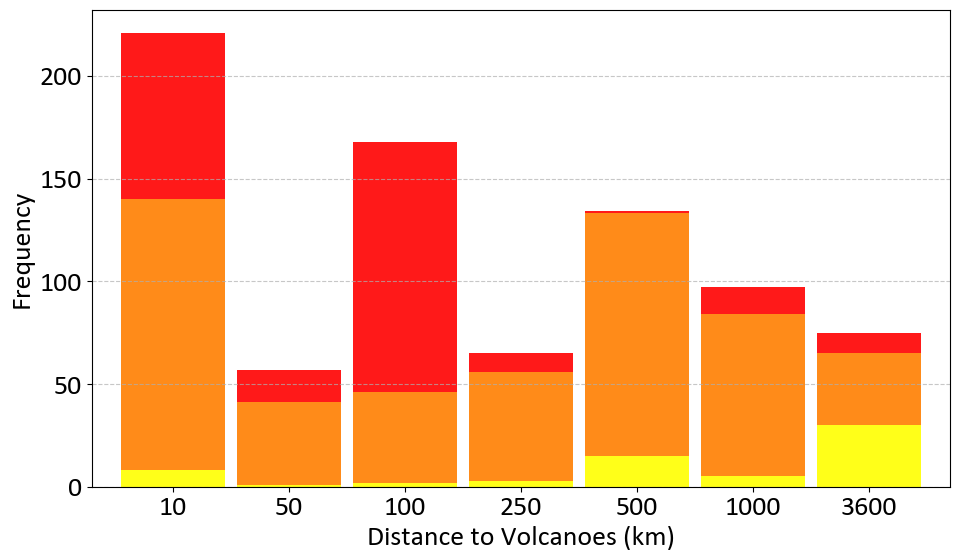

In [16]:
def plot_volcano_distance_histogram(df):
    """Generates a stacked bar chart showing the distribution of distance to volcanoes
    with the proportion of CO₂ flux in each category, with swapped axes."""

    # Define bins for distance to volcanoes
    bins = [0, 10, 50, 100, 250, 500, 1000, 3600]
    labels = [f"{int(bins[i+1])}" for i in range(len(bins)-1)]  

    # Categorize distance to volcanoes into defined bins
    df["Volcano_Distance_Categories"] = pd.cut(
        df["volcano_distance_km"], 
        bins=bins, 
        labels=labels, 
        include_lowest=True, 
        ordered=True
    )

    # Group data by CO₂ flux and volcano distance category
    grouped_data = df.groupby("Volcano_Distance_Categories")["Flux_log_range"].value_counts().unstack().fillna(0)

    # Maintain numerical order of categories
    grouped_data = grouped_data.reindex(labels)

    # Create figure with vertical bar chart (swapped axes)
    plt.figure(figsize=(10, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration with swapped axes:
    plt.xlabel("Distance to Volcanoes (km)")  
    plt.ylabel("Frequency")                 
    #plt.title("Distance to Nearest Volcano with Flux Proportion")
    plt.grid(axis='y', linestyle='--', alpha=0.7)  
    plt.xticks(rotation=0)
    # Adjust legend to avoid overlap
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.get_legend().remove()
    plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_5f.png", dpi=300, bbox_inches="tight")
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_volcano_distance_histogram(df)

**Observations:**
- Volcanic activity is a known contributor to CO₂ outgassing.
- Observing distance bins to volcanoes and the flux distribution can hint at whether volcanic proximity strongly influences CO₂ flux levels.

##### Key Findings (Tectonic & Structural Variables)

1. **Faults:** Preliminary results may suggest higher flux in proximity to faults.
2. **PGA:** A measure of seismic risk that may or may not correlate strongly with degassing processes.
3. **Mineralization & Mineral Commodities:** Could be proxy indicators of crustal permeability and hydrothermal processes.  
4. **Volcano Distance:** Notable impact if many high-flux points lie near active volcanoes.  

### Geological Variables

In this section, we examine key geological variables that may influence or correlate with CO₂ flux. These include permeability, porosity, water storage capacity, lithology, and geological province. Each variable can affect subsurface fluid flow, potentially impacting degassing processes and measured CO₂ emissions.


#### Permeability

<Figure size 1000x600 with 0 Axes>

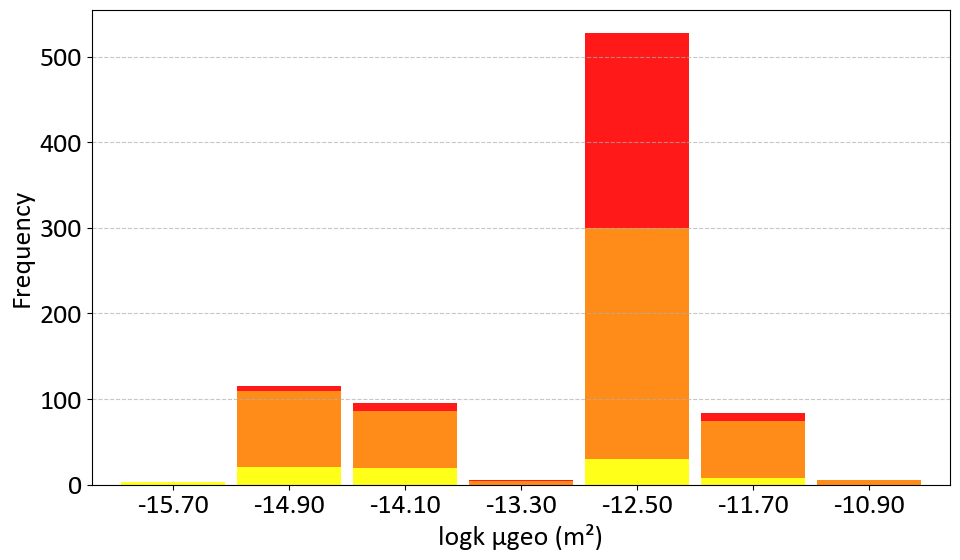

In [17]:
def plot_permeability_histogram(df):
    """Generates a stacked bar chart showing the distribution of permeability
    with the proportion of CO₂ flux in each category, swapping axes."""

    # Check if the column exists
    if "Permeability_permafrost" not in df.columns:
        print("Error: The column 'Permeability_permafrost' is not in the DataFrame.")
        return

    # Define bins based on the actual data range
    permeability_min = df["Permeability_permafrost"].min()
    permeability_max = df["Permeability_permafrost"].max()
    
    bins = np.linspace(permeability_min, permeability_max, num=8)  
    labels = [f"{bins[i+1]:.2f}" for i in range(len(bins)-1)]  

    # Categorize permeability into defined bins
    df["Permeability_Category"] = pd.cut(df["Permeability_permafrost"], bins=bins, labels=labels, include_lowest=True)

    # Check if there are data points within the bins
    if df["Permeability_Category"].isna().all():
        print("Error: No values in 'Permeability_permafrost' fall within the defined bins.")
        return

    # Group data by CO₂ flux and permeability category
    grouped_data = df.groupby("Permeability_Category")["Flux_log_range"].value_counts().unstack().fillna(0)

    # Ensure permeability values remain in numerical order
    grouped_data = grouped_data.reindex(labels)

    # Create figure with vertical bar chart 
    plt.figure(figsize=(10, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration with swapped axes:
    plt.xlabel("logk μgeo (m²)")  
    plt.ylabel("Frequency")  
    #plt.title("Permeability with Flux Proportion")  
    plt.grid(axis='y', linestyle='--', alpha=0.7)  
    plt.xticks(rotation=0)
    
    # Remove legend
    ax.get_legend().remove()
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left") 
    
    
    plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_6a.png", dpi=300, bbox_inches="tight")
    
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_permeability_histogram(df)


**Observations:**
- Permeability can strongly influence how fluids (including CO₂) move through the subsurface.
- We bin Permeability into discrete ranges and stack them by flux categories (**Low, Moderate, High**) to see if high permeability might coincide with increased CO₂ flux.

#### Porosity

<Figure size 1000x600 with 0 Axes>

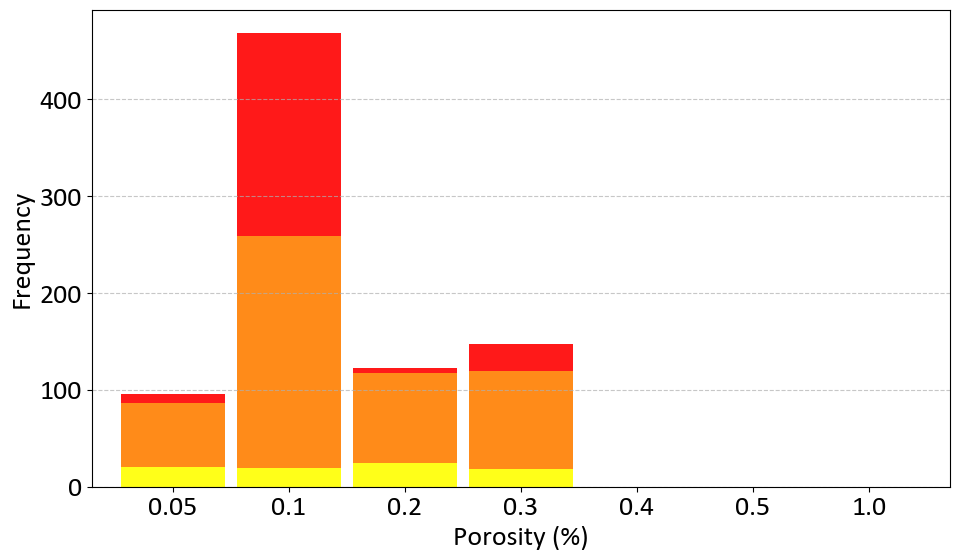

In [18]:
def plot_porosity_histogram(df):
    """Generates a stacked bar chart showing the distribution of porosity
    with the proportion of CO₂ flux in each category, swapping axes."""

    # Define bins for porosity
    bins = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
    labels = [f"{bins[i+1]}" for i in range(len(bins)-1)]  

    # Categorize porosity into defined bins
    df["Porosity_Category"] = pd.cut(df["Porosity"], bins=bins, labels=labels, include_lowest=True)

    # Group data by CO₂ flux and porosity category
    grouped_data = df.groupby("Porosity_Category")["Flux_log_range"].value_counts().unstack().fillna(0)

    # Maintain defined interval order
    grouped_data = grouped_data.reindex(labels)

    # Create figure with vertical bar chart 
    plt.figure(figsize=(10, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration with swapped axes:
    plt.xlabel("Porosity (%)")  
    plt.ylabel("Frequency")  
    #plt.title("Porosity with Flux Proportion")  
    plt.grid(axis='y', linestyle='--', alpha=0.7)  
    plt.xticks(rotation=0)
    
    # Remove legend
    ax.get_legend().remove()
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left") 
    
    
    plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_6b.png", dpi=300, bbox_inches="tight")
    
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_porosity_histogram(df)

**Observations:**
- Porosity represents the void space within rock or soil. High porosity could potentially store more fluids, influencing CO₂ accumulation or flow.
- This stacked histogram allows us to see how porosity levels might align with different CO₂ flux ranges.

#### Available Water Storage

<Figure size 1000x600 with 0 Axes>

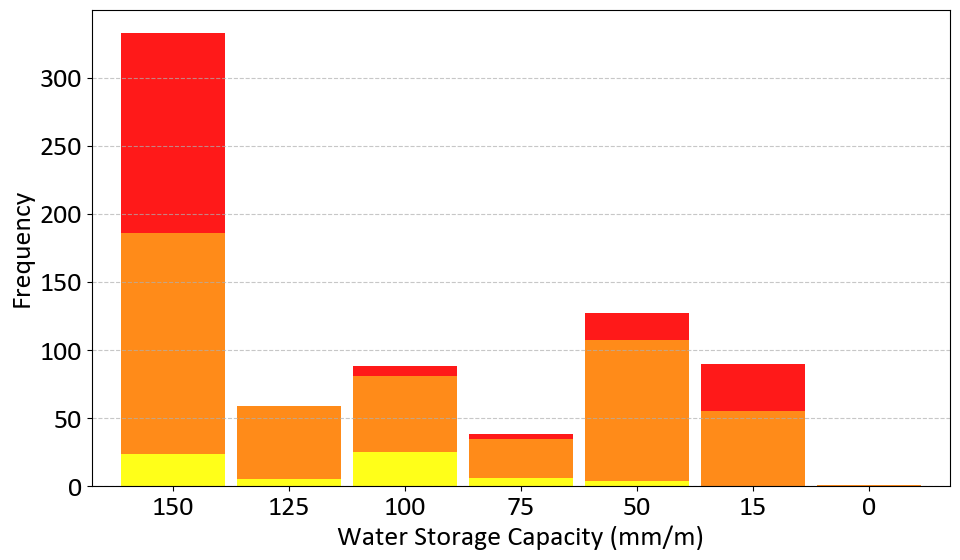

In [19]:
def plot_available_water_storage(df):
    import matplotlib.pyplot as plt
    import pandas as pd

    # 1) Reemplazar DEFINITIVAMENTE los códigos por mm/m en la columna original
    mapping = {1: 150, 2: 125, 3: 100, 4: 75, 5: 50, 6: 15, 7: 0}
    df["Available_Water_Storage_mm/m"] = df["Available_Water_Storage_mm/m"].map(mapping)

    # 2) Tabla de frecuencias (filas = AWS mm/m, columnas = rangos de flujo)
    grouped_data = pd.crosstab(
        df["Available_Water_Storage_mm/m"],
        df["Flux_log_range"]
    )

    # 3) Ordenar filas como quieres (si falta alguna, se rellena con 0)
    ordered_labels = [150, 125, 100, 75, 50, 15, 0]
    grouped_data = grouped_data.reindex(ordered_labels, fill_value=0)

    # 4) Asegurar tipo numérico por si acaso
    grouped_data = grouped_data.astype(float)

    # 5) Graficar
    plt.figure(figsize=(10, 6))
    reversed_map = plt.cm.get_cmap('autumn_r')
    ax = grouped_data.plot(
        kind="bar", stacked=True, colormap=reversed_map,
        width=0.9, alpha=0.9, figsize=(10, 6)
    )
    plt.xlabel("Water Storage Capacity (mm/m)")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=0)
    ax.get_legend().remove()
    plt.tight_layout()
    plt.show()


plot_available_water_storage(df)

**Observations:**
- Soil water storage can affect both microbial activity and gas transport in near-surface environments.
- Seeing how flux categories distribute across different storage capacities may reveal if wetter or drier soils have higher CO₂ emissions.


##### Key Findings for Geological Variables

1. **Permeability & Porosity**: Both parameters significantly govern fluid flow in the subsurface. High permeability or porosity can facilitate CO₂ migration.
2. **Available Water Storage**: Soil moisture and water capacity might influence microbial activity or fluid pathways, potentially affecting measured flux.

### Environmental Variables

In this section, we explore several environmental variables that may influence or correlate with CO₂ flux, such as soil pH, tree cover, soil organic carbon, temperature, and atmospheric CO₂ concentrations. These factors can affect biological activity, chemical reactions, and CO₂ exchange between the surface and the atmosphere.

#### Soil pH

<Figure size 1000x600 with 0 Axes>

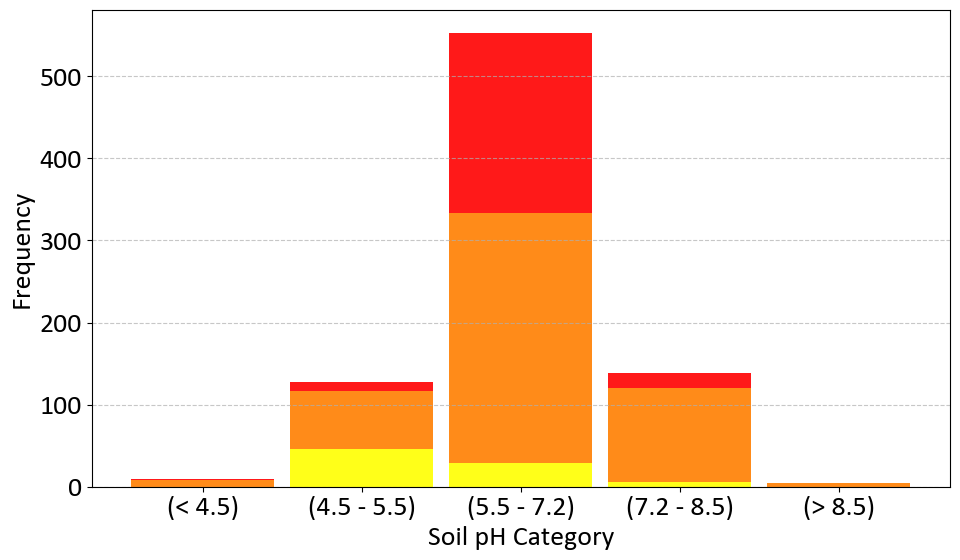

In [20]:
def plot_soil_ph_categories(df):
    """Generates a categorized bar chart of soil pH, showing the proportion of CO₂ flux without the descriptive statistics box."""

    # Create pH categories
    categories = pd.cut(df["Soil_pH_H2O"], 
                        bins=[0, 4.5, 5.5, 7.2, 8.5, 10], 
                        labels=["(< 4.5)", "(4.5 - 5.5)", "(5.5 - 7.2)", 
                                "(7.2 - 8.5)", "(> 8.5)"])

    # Add categories to the DataFrame
    df["Soil_pH_Category"] = categories

    # Group data by CO₂ flux and soil pH category
    grouped_data = df.groupby("Soil_pH_Category")["Flux_log_range"].value_counts().unstack().fillna(0)

    # Sort pH categories in the correct order
    category_order = ["(< 4.5)", "(4.5 - 5.5)", "(5.5 - 7.2)", 
                      "(7.2 - 8.5)", "(> 8.5)"]

    grouped_data = grouped_data.loc[category_order]
    plt.rcParams["font.family"] = "Calibri"  
    plt.rcParams["font.size"] = 20  
    
    # Create figure
    plt.figure(figsize=(10, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration
    plt.xlabel("Soil pH Category")
    plt.xticks(rotation=0)
    plt.ylabel("Frequency")
    #plt.title("Soil pH with Flux Proportion")  
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Remove legend
    ax.get_legend().remove()
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left") 
    

    plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_7a.png", dpi=300, bbox_inches="tight")
    
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_soil_ph_categories(df)

**Observations:**
- Soil pH can influence microbial activity and chemical speciation, potentially affecting CO₂ production or consumption.
- This stacked chart shows whether more acidic or alkaline soils align with higher or lower CO₂ flux.

#### Tree Cover Percentage

<Figure size 1000x600 with 0 Axes>

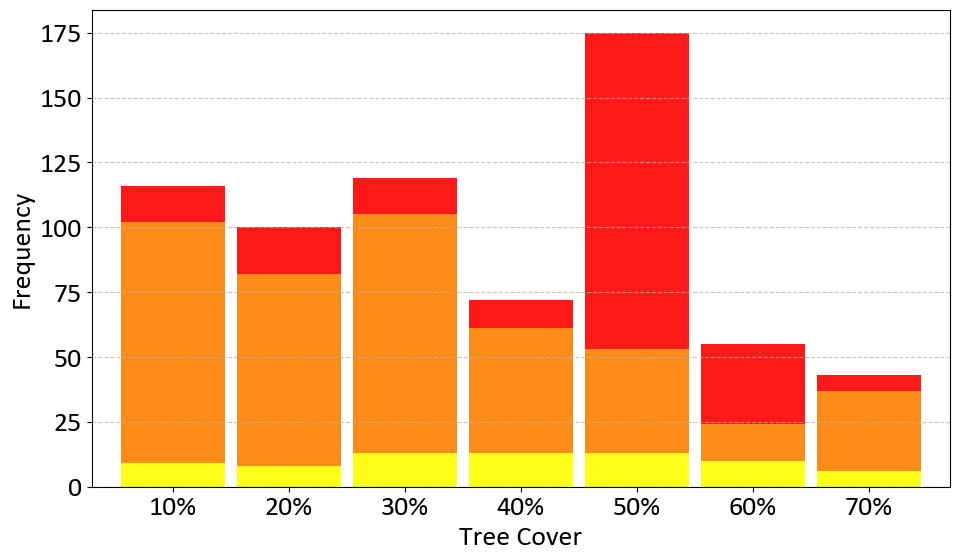

In [21]:
def plot_tree_cover_histogram(df):
    """Generates a stacked bar chart showing the distribution of tree cover
    with the proportion of CO₂ flux in each category, swapping axes."""

    # Define bins for tree cover
    bins = [0, 10, 20, 30, 40, 50, 60, 70]
    labels = [f"{bins[i+1]}%" for i in range(len(bins)-1)]  

    # Categorize tree cover into defined bins
    df["Tree_Cover_Category"] = pd.cut(df["Tree_Cover_Percentage"], bins=bins, labels=labels, include_lowest=True)

    # Group data by CO₂ flux and tree cover category
    grouped_data = df.groupby("Tree_Cover_Category")["Flux_log_range"].value_counts().unstack().fillna(0)

    # Ensure values remain in numerical order rather than frequency order
    grouped_data = grouped_data.reindex(labels)  

    # Create figure with vertical bar chart 
    plt.figure(figsize=(10, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration with swapped axes:
    plt.xlabel("Tree Cover")  
    plt.ylabel("Frequency")  
    #plt.title("Tree Cover with Flux Proportion")  
    plt.grid(axis='y', linestyle='--', alpha=0.7)  
    plt.xticks(rotation=0)
    
    # Remove legend
    ax.get_legend().remove()
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")  
    
    
    plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_7b.png", dpi=300, bbox_inches="tight")
    
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_tree_cover_histogram(df)

**Observations:**
- Vegetation cover can impact soil respiration and microclimate conditions.
- This chart indicates whether areas with higher or lower tree cover exhibit distinct CO₂ flux patterns.

#### Total Organic Carbon 

<Figure size 1200x600 with 0 Axes>

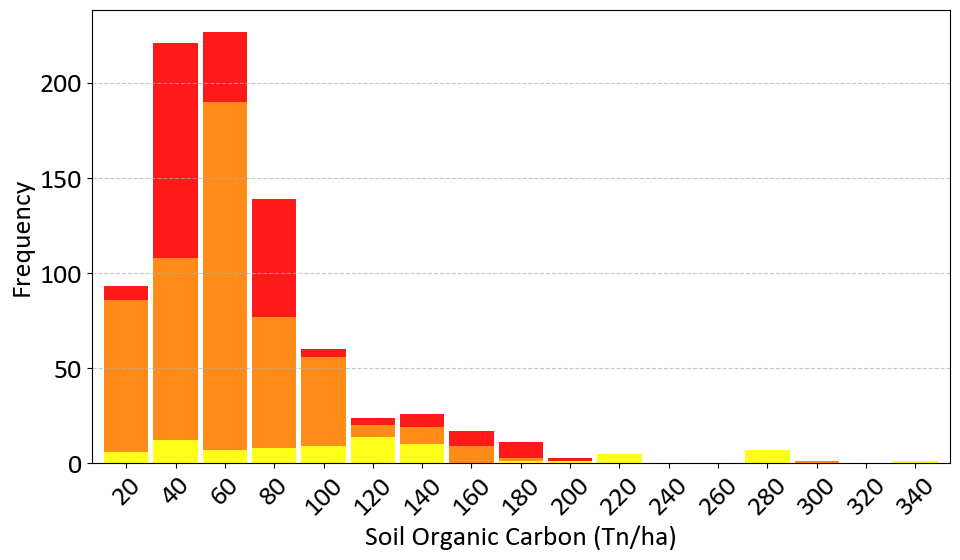

In [22]:
def plot_soil_organic_carbon(df):
    """Generates a histogram of soil organic carbon with 10-ton/ha intervals,
    showing the proportion of CO₂ flux without the descriptive statistics box."""
    
    # Filter relevant column
    soil_carbon = df["Soil_Organic_Carbon_ton_ha"]

    # Define histogram bins for soil organic carbon
    bins_soil = np.arange(0, df["Soil_Organic_Carbon_ton_ha"].max() + 10, 20)

    # Group data by CO₂ flux and soil organic carbon
    grouped_data = df.groupby(pd.cut(df["Soil_Organic_Carbon_ton_ha"], bins=bins_soil))["Flux_log_range"].value_counts().unstack().fillna(0)

    # Extract only final interval values for the X-axis
    tick_labels = [str(int(b)) for b in bins_soil[1:]]
    plt.rcParams["font.family"] = "Calibri"  
    plt.rcParams["font.size"] = 20  
    
    # Create figure
    plt.figure(figsize=(12, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration
    plt.xlabel("Soil Organic Carbon (Tn/ha)")
    plt.ylabel("Frequency")
    #plt.title("Soil Organic Carbon with Flux Proportion")  
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust X-axis labels to show only final interval values
    ax.set_xticklabels(tick_labels, rotation=45)
    
    # Remove legend
    ax.get_legend().remove()
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")  
    
    # Save the image with adjusted dpi
    plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_7c.png", dpi=300, bbox_inches="tight")
    
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_soil_organic_carbon(df)

**Observations:**
- Higher soil organic carbon often corresponds to greater microbial activity, potentially increasing CO₂ flux from respiration.
- This plot helps determine if higher SOC bins align with high flux categories.

#### Annual Mean Temperature

<Figure size 1200x600 with 0 Axes>

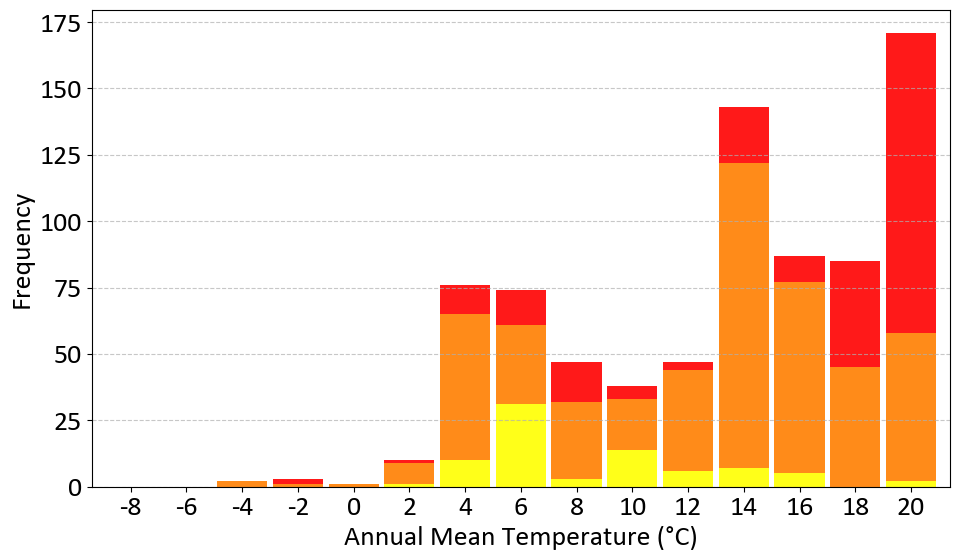

In [23]:
def plot_annual_mean_temperature(df):
    """Generates a histogram of annual mean temperature with 2°C intervals,
    showing the proportion of CO₂ flux without the descriptive statistics box."""
    
    # Filter relevant column
    annual_temp = df["Annual_Mean_Temperature_C"]

    # Define histogram bins for annual mean temperature
    bins_temp = np.arange(-10, 22, 2)

    # Group data by CO₂ flux and annual mean temperature
    grouped_data = df.groupby(pd.cut(df["Annual_Mean_Temperature_C"], bins=bins_temp))["Flux_log_range"].value_counts().unstack().fillna(0)

    # Extract only final interval values for the X-axis
    tick_labels = [str(int(b)) for b in bins_temp[1:]]
    plt.rcParams["font.family"] = "Calibri"  
    plt.rcParams["font.size"] = 20  
    
    # Create figure
    plt.figure(figsize=(12, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration
    plt.xlabel("Annual Mean Temperature (°C)")
    plt.ylabel("Frequency")
    #plt.title("Distribution of Mean Temperature with Flux Proportion")  
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust X-axis labels to show only final interval values
    ax.set_xticklabels(tick_labels, rotation=0)
    
    # Remove legend
    ax.get_legend().remove()
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")  
    
    plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_7d.png", dpi=300, bbox_inches="tight")
    
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_annual_mean_temperature(df)

**Observations:**
- Temperature is a key driver of atmospheric and climatic processes, shaping local weather conditions and influencing how CO₂ is distributed and exchanged near the surface.
- By segmenting temperature into 2°C bins, you can check if warmer or colder conditions coincide with certain flux levels.

##### Key patterns for Environmental Variables

1. **Soil pH:** Influences microbial and chemical processes.  
2. **Tree Cover:** Affects net primary production and microclimate factors.  
3. **Soil Organic Carbon (SOC):** A proxy for biological activity that can drive CO₂ production in soils.  
4. **Annual Mean Temperature:** Warmer regions may have higher respiration rates, but many confounding factors exist.

## **Data Cleaning and Feature Transformation**

In this section, we prepare the dataset for machine-learning modeling by removing irrelevant fields, transforming selected variables, and standardizing the feature names. We begin by dropping columns that are not used as predictors in the regression workflow, such as coordinates, original flux values, categorical labels, and intermediate classification outputs. Next, we apply an inverse-distance transformation to variables representing distances to geological features (faults, volcanoes, mineralizations, and mineral commodities). This transformation enhances spatial influence by giving more weight to sites located closer to these features, while also preventing division by zero through the use of a small offset value. Finally, we rename all predictor columns to clear, human-readable labels to ensure consistency throughout the analysis, figures, and interpretation. Together, these steps produce a clean and well-structured dataset ready for scaling, model training, and evaluation.


### Removing Unused Columns

In [24]:
print("Columns in DataFrame:\n", df.columns.tolist())

columns_to_drop = [
    'Longitude (x)', 'Latitude (y)','Flux (gm-2d-1)', 'Flux_log_range', 'Fault_Distance_Categories', 'PGA_Category', 'Mineral_Commodity_Distance_Categories', 'Mineralization_Distance_Categories', 'Volcano_Distance_Categories', 'Permeability_Category', 'Porosity_Category', 'Soil_pH_Category', 'Tree_Cover_Category'
]

co2_flux = df.drop(columns=columns_to_drop, errors='ignore')
print("\nDataFrame shape after dropping columns:", co2_flux.shape)

Columns in DataFrame:
 ['Longitude (x)', 'Latitude (y)', 'Flux (gm-2d-1)', 'Bouguer_Anomaly_mGal', 'Heat_Flow_mW_m2', 'Annual_Mean_Temperature_C', 'Soil_Organic_Carbon_ton_ha', 'Soil_pH_H2O', 'faults_distance_km', 'mineralization_distance_km', 'volcano_distance_km', 'mineral_commodity_distance_km', 'Available_Water_Storage_mm/m', 'Tree_Cover_Percentage', 'Porosity', 'Permeability_permafrost', 'PGA_Mean', 'Flux_log', 'Flux_log_range', 'Fault_Distance_Categories', 'PGA_Category', 'Mineral_Commodity_Distance_Categories', 'Mineralization_Distance_Categories', 'Volcano_Distance_Categories', 'Permeability_Category', 'Porosity_Category', 'Soil_pH_Category', 'Tree_Cover_Category']

DataFrame shape after dropping columns: (835, 15)


### Inverse-Distance Transformation

We apply an inverse-distance transformation so that:
- Shorter distances receive **greater weight** (high values when using 1/d²).
- Very large distances have **minimal influence** on the model.

In [25]:


columns_to_transform = [
    'faults_distance_km',
    'volcano_distance_km',
    'mineralization_distance_km',
    'mineral_commodity_distance_km'
]

small_value = 0.001  # Represents 10 meters, avoids division by zero
for col in columns_to_transform:
    co2_flux[col] = co2_flux[col].replace(0, small_value)
    co2_flux[col] = 1 / (co2_flux[col]**2)  # Inverse transformation

**Rationale:**  
- Emphasize the effect of proximity to geological features (e.g., faults, volcanoes).  
- Strongly penalize extremely large distances (e.g., >300 km).

### Renaming Columns

We rename selected columns for better presentation in subsequent analyses and plots.

In [26]:
column_mapping = {
    'Bouguer_Anomaly_mGal': 'Bouguer Anomaly (mGal)',
    'Heat_Flow_mW_m2': 'Heat Flow (mW/m²)',
    'Annual_Mean_Temperature_C': 'Annual Mean Temperature (°C)',
    'Soil_Organic_Carbon_ton_ha': 'Soil Organic Carbon (Tn/ha)',
    'Soil_pH_H2O': 'Soil pH',
    'faults_distance_km': 'Distance to Nearest Fault (Km)',
    'mineralization_distance_km': 'Distance to Nearest Mineralization (Km)',
    'volcano_distance_km': 'Distance to Nearest Volcano (Km)',
    'mineral_commodity_distance_km': 'Distance to Nearest Mineral Product (Km)',
    'Available_Water_Storage_mm/m': 'Available Water Storage (mm/m)',
    'Tree_Cover_Percentage': 'Tree Cover (%)',
    'Porosity': 'Porosity (%)',
    'Permeability_permafrost': 'Permeability (logk m²)',
    'PGA_Mean': 'PGA (g)',
    'Flux_log': 'Log of Flux'
}


co2_flux.rename(columns=column_mapping, inplace=True)
print("Columns after renaming:\n", co2_flux.columns.tolist())

Columns after renaming:
 ['Bouguer Anomaly (mGal)', 'Heat Flow (mW/m²)', 'Annual Mean Temperature (°C)', 'Soil Organic Carbon (Tn/ha)', 'Soil pH', 'Distance to Nearest Fault (Km)', 'Distance to Nearest Mineralization (Km)', 'Distance to Nearest Volcano (Km)', 'Distance to Nearest Mineral Product (Km)', 'Available Water Storage (mm/m)', 'Tree Cover (%)', 'Porosity (%)', 'Permeability (logk m²)', 'PGA (g)', 'Log of Flux']


## **Feature Selection and Correlation Analysis**

In this section, we examine the relationships between all predictor variables and the log-transformed CO₂ flux to support feature selection and identify potential multicollinearity. To obtain a more complete picture of these relationships, we compute both Pearson (linear) and Spearman (rank-based) correlation matrices. We then merge them into a single combined heatmap: the upper triangle displays Pearson correlations, while the lower triangle shows Spearman correlations. This hybrid representation highlights both linear and monotonic dependencies across all variables. Based on the resulting correlations, we generate an initial list of preselected features to be carried forward into the machine-learning modeling pipeline. This step helps focus the analysis on meaningful predictors while improving model interpretability and performance.

### Combined Correlation Matrix (Spearman & Pearson)

This combined matrix visualizes Pearson correlation on the upper triangle and Spearman correlation on the lower triangle, reducing the number of figures needed.

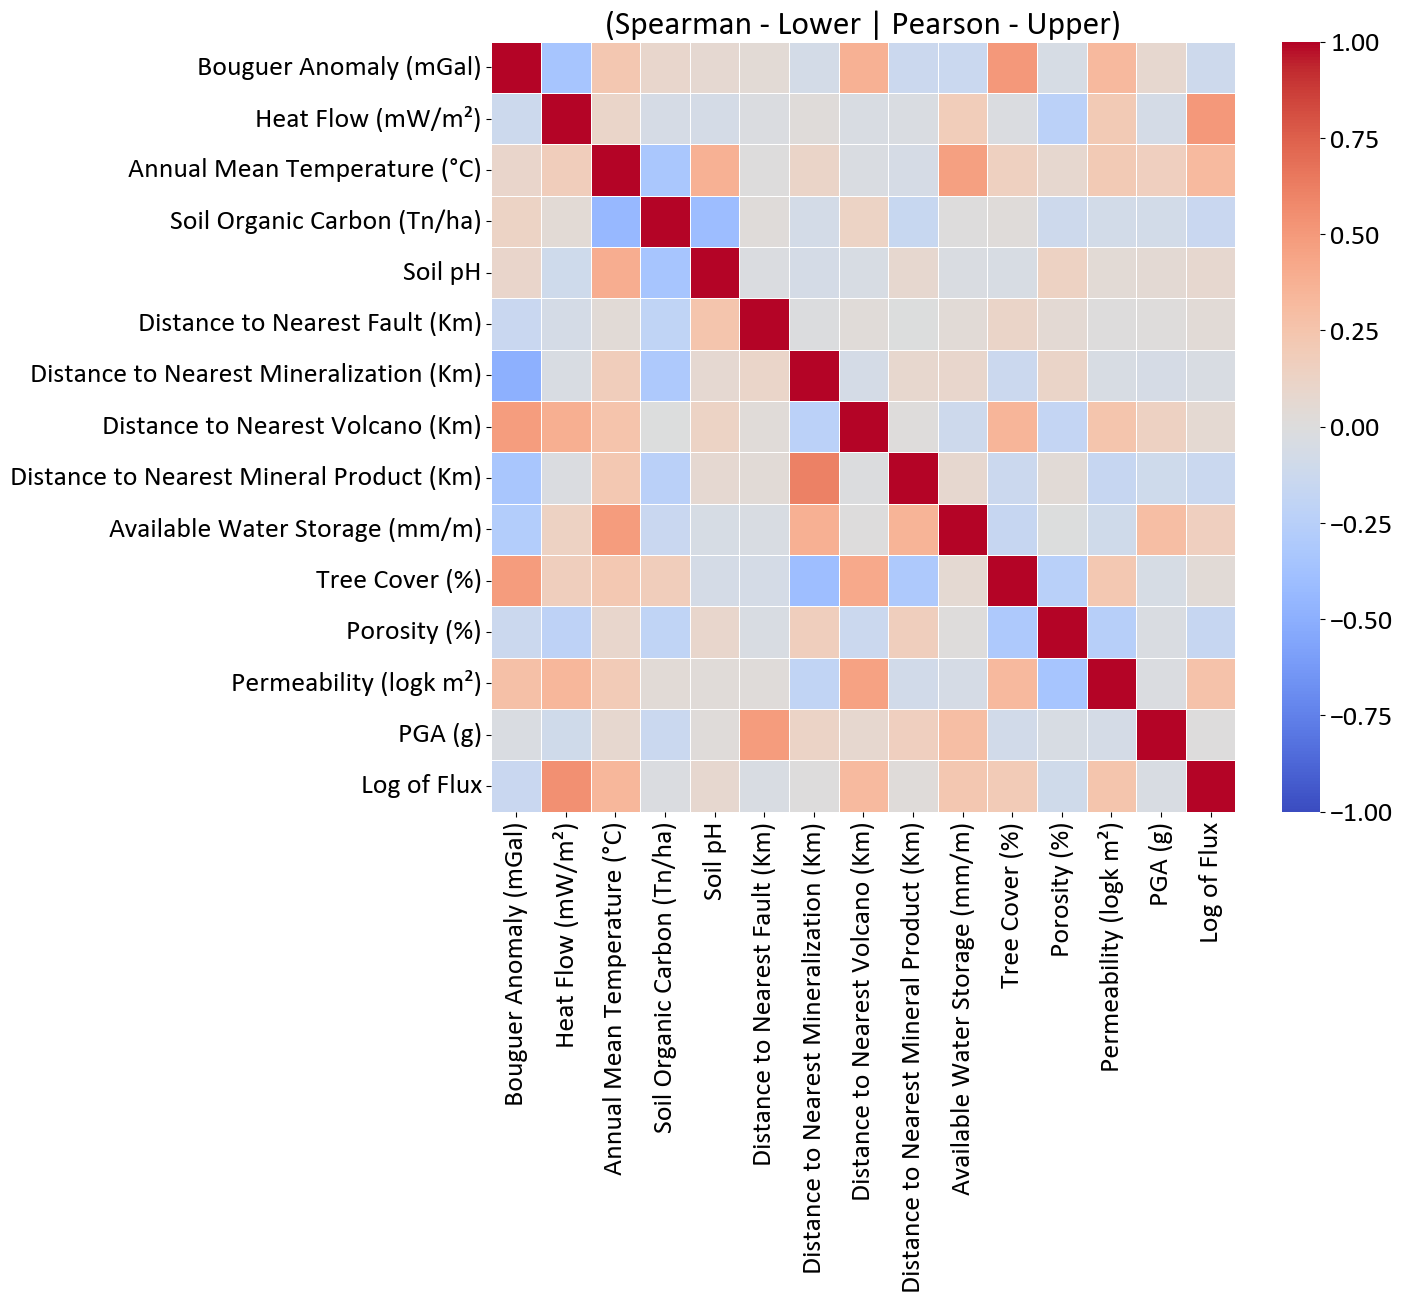

In [27]:
# Compute correlation matrices
pearson_corr = co2_flux.corr(method='pearson')
spearman_corr = co2_flux.corr(method='spearman')

# Create a copy of Pearson for the combined matrix
combined_corr = pearson_corr.copy()

# Create masks for the upper and lower triangles (excluding diagonal)
mask_upper = np.triu(np.ones(pearson_corr.shape, dtype=bool), k=1)  # Upper triangle
mask_lower = np.tril(np.ones(spearman_corr.shape, dtype=bool), k=-1)  # Lower triangle

# Fill the combined matrix with corresponding correlations
for i in range(len(pearson_corr.columns)):
    for j in range(len(pearson_corr.columns)):
        if mask_upper[i, j]:  # If in the upper part -> Pearson
            combined_corr.iloc[i, j] = pearson_corr.iloc[i, j]
        elif mask_lower[i, j]:  # If in the lower part -> Spearman
            combined_corr.iloc[i, j] = spearman_corr.iloc[i, j]

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Draw the combined heatmap
sns.heatmap(combined_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, 
            xticklabels=pearson_corr.columns, yticklabels=pearson_corr.columns, linewidths=0.5, ax=ax)

# Add title
ax.set_title("(Spearman - Lower | Pearson - Upper)")
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_8.png", dpi=300, bbox_inches="tight")

# Show figure
plt.show()

**Conclusion:**  
- A single heatmap reflects both linear (upper) and monotonic (lower) relationships.  
- Facilitates deciding which variables are more relevant or influential based on the type of correlation you want to capture.

#### Final Feature List and Data Export

In [28]:
features_preselected = [col for col in co2_flux.columns if col != 'Log of Flux']
print("Preselected features:\n", features_preselected)

Preselected features:
 ['Bouguer Anomaly (mGal)', 'Heat Flow (mW/m²)', 'Annual Mean Temperature (°C)', 'Soil Organic Carbon (Tn/ha)', 'Soil pH', 'Distance to Nearest Fault (Km)', 'Distance to Nearest Mineralization (Km)', 'Distance to Nearest Volcano (Km)', 'Distance to Nearest Mineral Product (Km)', 'Available Water Storage (mm/m)', 'Tree Cover (%)', 'Porosity (%)', 'Permeability (logk m²)', 'PGA (g)']


**Note:**  
- We keep `Log of Flux` as the target variable. 

## **Predictive Modeling**

In this section, we build and evaluate several machine-learning models to predict the logarithm of the CO₂ degassing flux from the selected environmental and geological features. We first separate the dataset into predictors (X) and target (y), apply median imputation to remaining missing values, and standardize the features to ensure that all variables are on comparable scales. The data is then split into three subsets: a training set used to fit the models, a validation set for model selection and hyperparameter tuning, and an independent test set to assess final predictive performance.

We train multiple regression algorithms, including Support Vector Regression (SVR), K-Nearest Neighbors (KNN), Decision Trees, Random Forests, Gradient Boosting, and a Stacking Regressor that combines several base models. For each model, we perform cross-validated hyperparameter optimization, compute performance metrics (R², MSE, MAE) on both validation and test sets, and inspect learning curves to check for underfitting or overfitting. We also generate diagnostic plots such as predicted vs. observed values, feature-importance rankings, partial dependence plots (PDPs), and SHAP-based explanations. Together, these analyses allow us to identify the most robust model and to understand which predictors contribute most strongly to the spatial variability of CO₂ degassing.

### Splitting Features (X) and Target (y)

We drop the target column 'Log of Flux' to form X, and use 'Log of Flux' as y. Then, we apply a standard scaler to the features.

In [29]:
# Separate features (X) and target (y)
X = co2_flux.drop(columns=['Log of Flux'])
y = co2_flux['Log of Flux']

imputer = SimpleImputer(strategy='median')
X['Available Water Storage (mm/m)'] = imputer.fit_transform(
    X[['Available Water Storage (mm/m)']]
)

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame from the scaled features
X_df = pd.DataFrame(X_scaled, columns=features_preselected)

### Train-Validation-Test Split

We split the dataset such that:
- 70% is used for training (with cross-validation to tune hyperparameters).
- The remaining 30% is split evenly for validation and testing.

This ensures we have separate data for hyperparameter tuning (training + CV) and final model performance evaluation (test + validation).

In [30]:
# 70% train, 30% test+validation
X_train, X_test_val, y_train, y_test_val = train_test_split(
    X_df, y, test_size=0.30, random_state=42
)

# Then split the remaining 30% equally between validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_test_val, y_test_val, test_size=0.50, random_state=42
)

print(f"Training set:   {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set:       {X_test.shape}, {y_test.shape}")

Training set:   (584, 14), (584,)
Validation set: (125, 14), (125,)
Test set:       (126, 14), (126,)


**Note**:  
- When performing hyperparameter tuning (e.g., with GridSearchCV), we typically use a cross-validation split **within** the training data to avoid data leakage and to maximize training examples.
- After finding the best hyperparameters, we can finalize the model and evaluate on validation and test sets.

### Training and Evaluating Models

Below, we train and evaluate different models. The workflow is:

1. Define the model and parameter grid for hyperparameter tuning.
2. Use GridSearchCV with k-fold cross-validation on the training data.
3. Evaluate the best estimator on **test** and **validation** sets.
4. Plot learning curves to diagnose bias/variance issues.
5. Use interpretability tools (Permutation Importance, Partial Dependence, and SHAP) to understand the model’s behavior.

In [31]:
# Diagnosis 1: before climbing
print("NaN per column in X (before scaling):")
print(X.isna().sum().sort_values(ascending=False).head(20))

# Diagnosis 2: after scaling and building X_df
print("\nNaN totals in X_df:", pd.isna(X_df).sum().sum())
print(pd.isna(X_df).sum().sort_values(ascending=False).head(20))


NaN per column in X (before scaling):
Bouguer Anomaly (mGal)                      0
Heat Flow (mW/m²)                           0
Annual Mean Temperature (°C)                0
Soil Organic Carbon (Tn/ha)                 0
Soil pH                                     0
Distance to Nearest Fault (Km)              0
Distance to Nearest Mineralization (Km)     0
Distance to Nearest Volcano (Km)            0
Distance to Nearest Mineral Product (Km)    0
Available Water Storage (mm/m)              0
Tree Cover (%)                              0
Porosity (%)                                0
Permeability (logk m²)                      0
PGA (g)                                     0
dtype: int64

NaN totals in X_df: 0
Bouguer Anomaly (mGal)                      0
Heat Flow (mW/m²)                           0
Annual Mean Temperature (°C)                0
Soil Organic Carbon (Tn/ha)                 0
Soil pH                                     0
Distance to Nearest Fault (Km)              0
Distan

In [32]:
# -----------------------
# Function to plot learning curve
# -----------------------

def plot_learning_curve(estimator, X, y, title="Learning Curve"):
    """
    Plots the learning curve of a model and saves it as an image.
    
    Parameters:
        estimator: Machine Learning model.
        X: Predictor variables.
        y: Target variable.
        title: Plot title (optional).
    """
    # Compute learning curves
    train_sizes, train_scores, cv_scores = learning_curve(estimator, X, y, cv=5, scoring='r2', n_jobs=-1,
                                                          train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    
    # Create figure
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, cv_scores_mean, 'o-', color="g", label="CV score")
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("R²")
    plt.legend(loc="best")
    plt.grid(True)
    
    # Get model name and create filename
    model_name = type(estimator).__name__  # Extracts the model class name
    file_name = f"{model_name}_Learning_Curve.png"
    
    # Save figure
    #plt.savefig(file_name, dpi=600, bbox_inches="tight")
    
    # Show figure
    plt.show()

    print(f"Learning curve saved as: {file_name}")

In [33]:
# We'll store our results in a list for a final comparison
results = []

### 7.3.1 **Support Vector Regression (SVR)**

We use GridSearchCV to explore different kernels, C values, gamma settings, and epsilon values. Then we pick the best model and evaluate it.

In [34]:
# -----------------------
# 2. Model: SVR (Support Vector Regression)
# -----------------------
print("\n=== SVR ===")
svr = SVR()
param_grid_svr = {
    'kernel': ['rbf', 'poly', 'sigmoid'],  
    'C': [1e-3, 1e-1, 1, 10, 100],         
    'gamma': ['scale', 'auto'],
    'epsilon': [0.001, 0.01, 0.1, 0.5, 1], 
    
}
grid_svr = GridSearchCV(svr, param_grid_svr, scoring='r2', cv=5, n_jobs=-1, verbose=1)
grid_svr.fit(X_train, y_train)
print("Mejores parámetros SVR:", grid_svr.best_params_)
best_svr = grid_svr.best_estimator_


=== SVR ===
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Mejores parámetros SVR: {'C': 10, 'epsilon': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}


In [35]:
# Evaluate on TEST set
y_pred_test = best_svr.predict(X_test)
svr_test_r2 = r2_score(y_test, y_pred_test)
svr_test_mse = mean_squared_error(y_test, y_pred_test)
svr_test_mae = mean_absolute_error(y_test, y_pred_test)

In [36]:
# Evaluate on VALIDATION set
y_pred_val = best_svr.predict(X_val)
svr_val_r2 = r2_score(y_val, y_pred_val)
svr_val_mse = mean_squared_error(y_val, y_pred_val)
svr_val_mae = mean_absolute_error(y_val, y_pred_val)

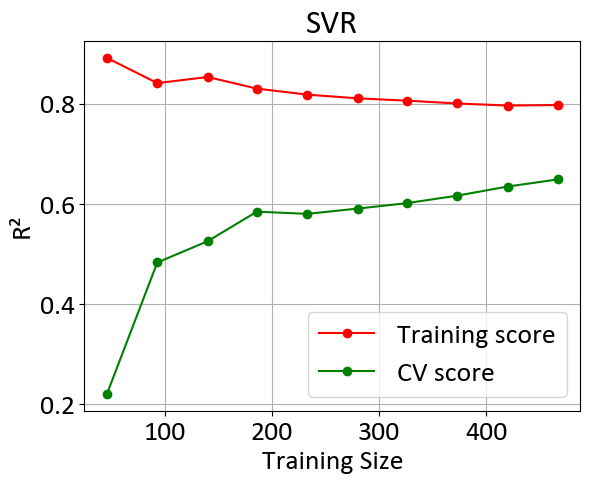

Learning curve saved as: SVR_Learning_Curve.png


In [37]:
# Plot learning curve for SVR
plot_learning_curve(best_svr, X_train, y_train, title="SVR")

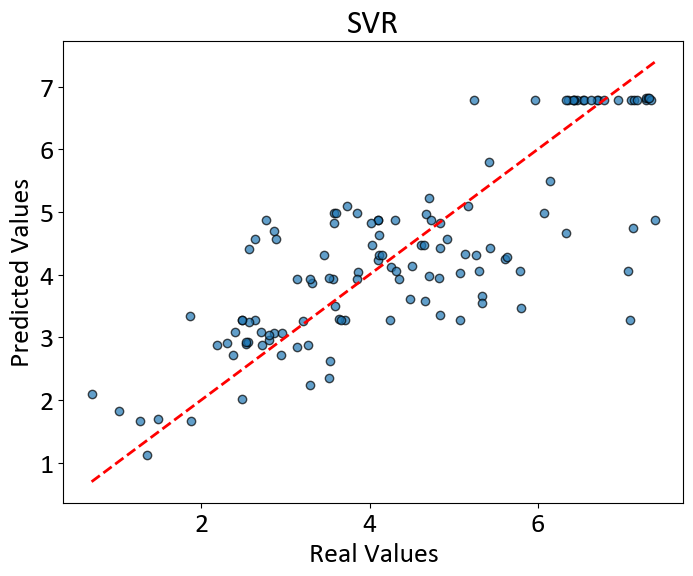

In [38]:
# -----------------------------------------------
# Plot 1: Predicted vs Actual Values (TEST)
# -----------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_val, alpha=0.7, edgecolor='k')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--', lw=2)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("SVR")
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_10a.png", dpi=300, bbox_inches="tight") 
plt.show()

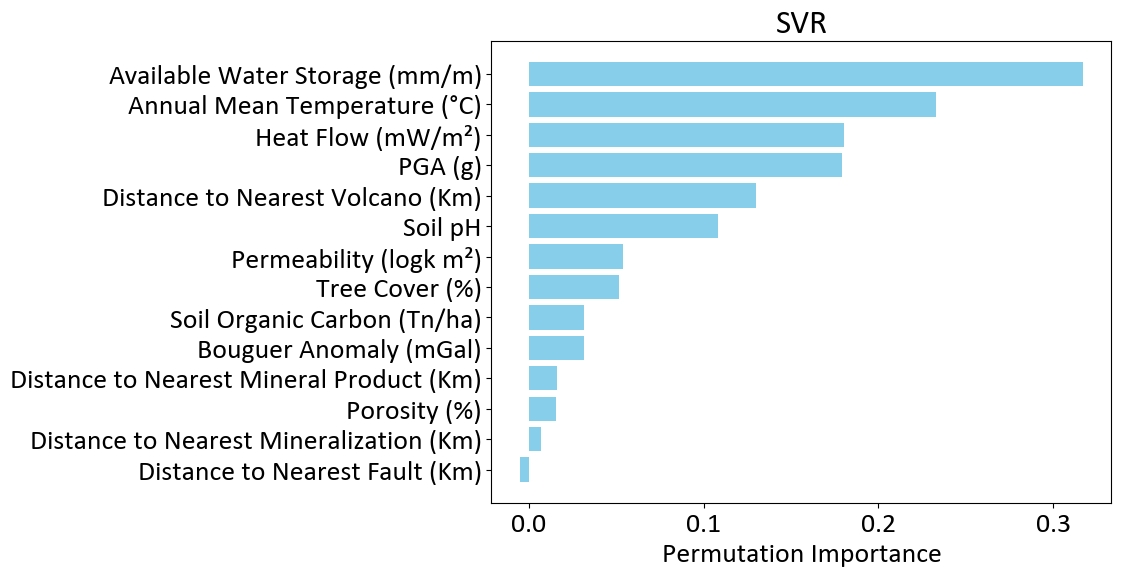

In [39]:
# ==============================
# 1. Permutation Importance
# ==============================
perm_importance_svr = permutation_importance(best_svr, X_val, y_val, n_repeats=10, random_state=42)

# Sort features by importance (highest to lowest)
sorted_idx = np.argsort(perm_importance_svr.importances_mean)[::-1]
features_sorted = np.array(features_preselected)[sorted_idx]

# Feature importance plot
plt.figure(figsize=(8,6))
plt.barh(features_sorted, perm_importance_svr.importances_mean[sorted_idx], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance")
plt.title("SVR")
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_11a.png", dpi=300, bbox_inches="tight")  
plt.show()

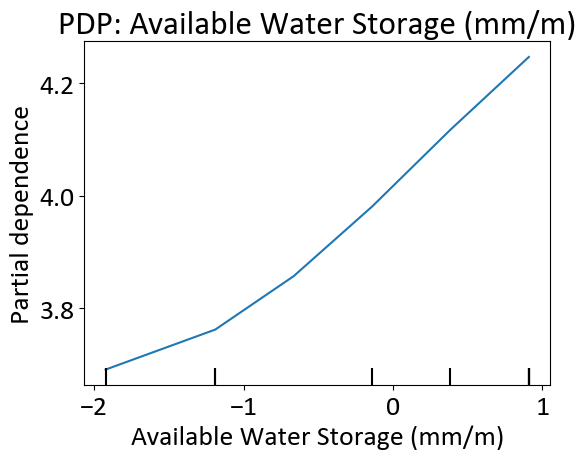

In [40]:
# ==========================================
# 2. Partial Dependence Plot for the most important variable
# ==========================================
fig, ax = plt.subplots(figsize=(6,5))
# Plot the PDP for the most important feature
top_features = [features_sorted[0] if len(features_sorted) else X_val.select_dtypes('number').columns[0]]
PartialDependenceDisplay.from_estimator(best_svr, X_val, [top_features[0]], ax=ax)
ax.set_title(f"PDP: {top_features[0]}")
plt.tight_layout()
#plt.savefig("SVR_Partial_Dependence_First_Feature.png", dpi=300, bbox_inches="tight")
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

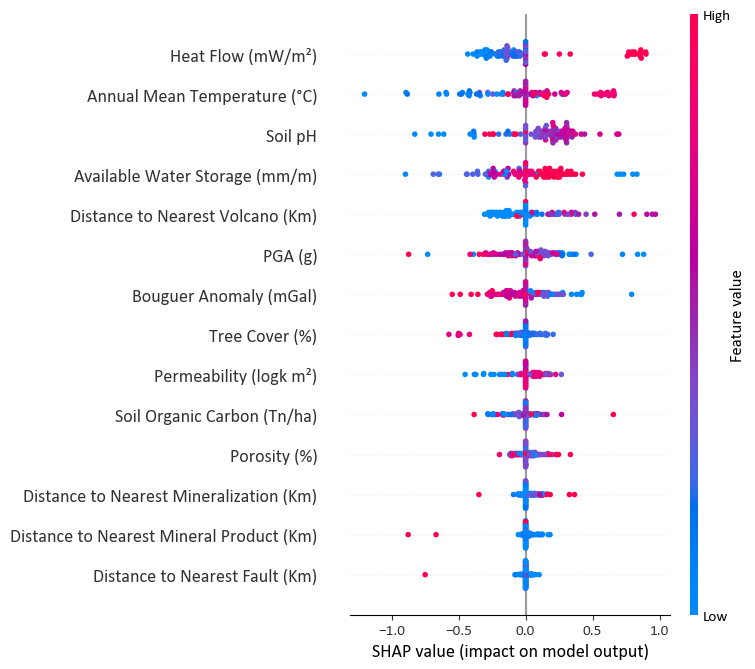

In [41]:
# ==============================
# 3. SHAP Summary with KernelExplainer
# ==============================

if isinstance(X_train, pd.DataFrame):
    X_train_sample = X_train.sample(50, random_state=42)
else:
    X_train_sample = X_train[:50]

if isinstance(X_test, pd.DataFrame):
    X_test_sample = X_val.sample(100, random_state=42)
else:
    X_test_sample = X_val[:100]

# Define the explainer using the SVR model's predict function
explainer = shap.KernelExplainer(best_svr.predict, X_train_sample)

# Compute SHAP values for the test sample (adjust nsamples based on available resources)
shap_values = explainer.shap_values(X_test_sample, nsamples=100)

# Create SHAP figure and save it
plt.figure()  # Create a new figure before plotting SHAP summary
shap.summary_plot(shap_values, X_test_sample, feature_names=features_preselected, show=False) 

# Save the image before displaying it
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_12a.png", dpi=300, bbox_inches="tight")

# Show the image
plt.show()

In [42]:
results.append({
    'Modelo': 'SVR_Regressor',
    'Test_R2': svr_test_r2,
    'Test_MSE': svr_test_mse,
    'Test_MAE': svr_test_mae,
    'Val_R2': svr_val_r2,
    'Val_MSE': svr_val_mse,
    'Val_MAE': svr_val_mae
})

## KNN REGRESSOR

In [43]:
# -----------------------
# Model: KNN Regressor
# -----------------------
print("\n=== KNN Regressor ===")
knn = KNeighborsRegressor()

# Define a hyperparameter grid for KNN
param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'p': [1, 2]  # Only used if 'metric' is 'minkowski'
}

# We perform hyperparameter search with cross-validation
grid_knn = GridSearchCV(knn, param_grid_knn, scoring='r2', cv=5, n_jobs=-1, verbose=1)
grid_knn.fit(X_train, y_train)
print("Mejores parámetros KNN:", grid_knn.best_params_)
best_knn = grid_knn.best_estimator_

# Evaluation in TEST
y_pred_test = best_knn.predict(X_test)
knn_test_r2 = r2_score(y_test, y_pred_test)
knn_test_mse = mean_squared_error(y_test, y_pred_test)
knn_test_mae = mean_absolute_error(y_test, y_pred_test)

# Evaluation in VALIDATION
y_pred_val = best_knn.predict(X_val)
knn_val_r2 = r2_score(y_val, y_pred_val)
knn_val_mse = mean_squared_error(y_val, y_pred_val)
knn_val_mae = mean_absolute_error(y_val, y_pred_val)


=== KNN Regressor ===
Fitting 5 folds for each of 2560 candidates, totalling 12800 fits
Mejores parámetros KNN: {'algorithm': 'ball_tree', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


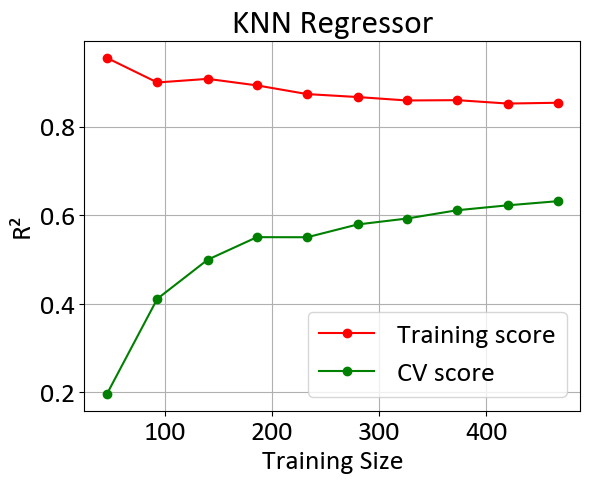

Learning curve saved as: KNeighborsRegressor_Learning_Curve.png


In [44]:
# Learning curve
plot_learning_curve(best_knn, X_train, y_train, title="KNN Regressor")


results.append({
    'Modelo': 'KNN_Regressor',
    'Test_R2': knn_test_r2,
    'Test_MSE': knn_test_mse,
    'Test_MAE': knn_test_mae,
    'Val_R2': knn_val_r2,
    'Val_MSE': knn_val_mse,
    'Val_MAE': knn_val_mae
})

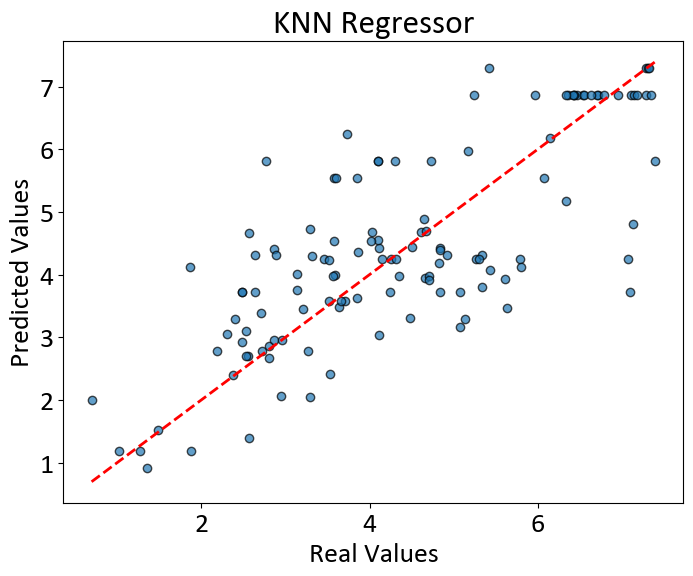

In [45]:
# -----------------------------------------------
# Plot 1: Predicted vs Actual Values (TEST) for KNN
# -----------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_val, alpha=0.7, edgecolor='k')
# Ideal reference line (y = x)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--', lw=2)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("KNN Regressor")
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_10b.png", dpi=300, bbox_inches="tight") 
plt.show()

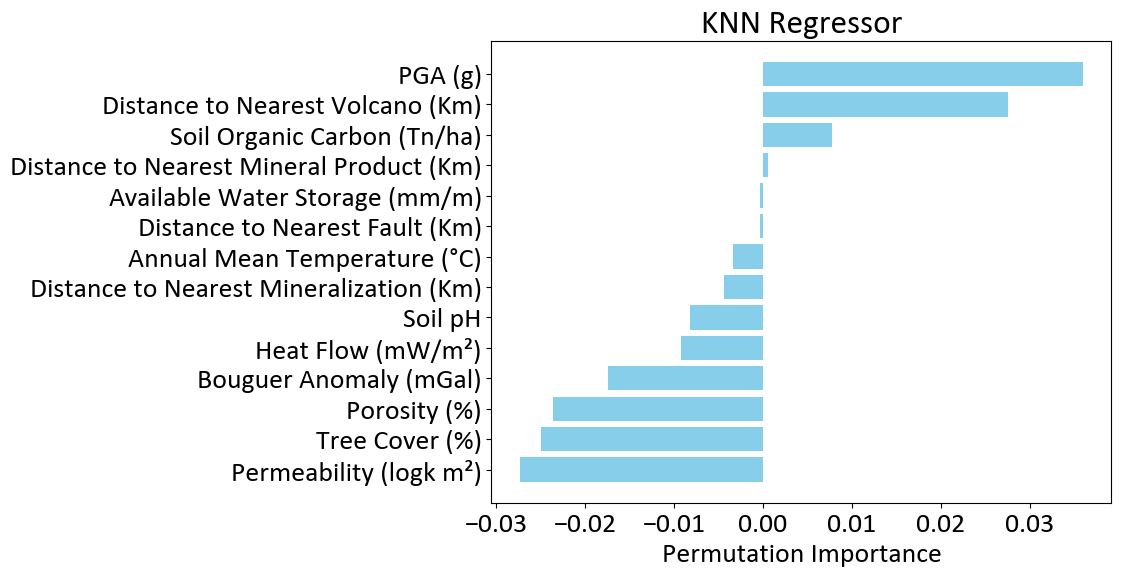

In [46]:
# 1. Compute feature importance using permutation
perm_importance_knn = permutation_importance(best_knn, X_val, y_val, n_repeats=10, random_state=42)

# Sort features by importance (highest to lowest)
sorted_idx = np.argsort(perm_importance_knn.importances_mean)[::-1]
features_sorted = np.array(features_preselected)[sorted_idx]

# --- Feature Importance Plot ---
plt.figure(figsize=(8,6))
plt.barh(features_sorted, perm_importance_knn.importances_mean[sorted_idx], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance")
plt.title("KNN Regressor")
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_11b.png", dpi=300, bbox_inches="tight")  
plt.show()

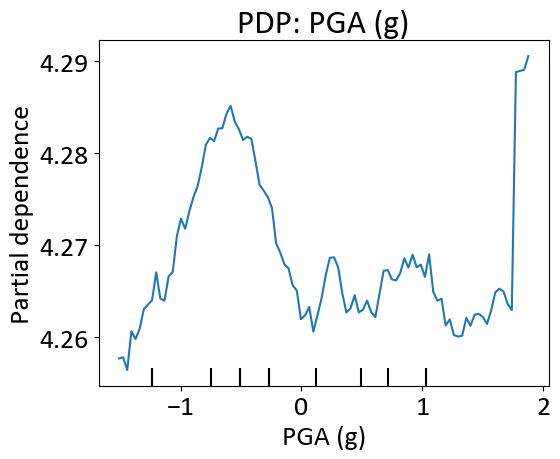

In [47]:
# 2. Partial Dependence Plot (PDP) for the most important variable
fig, ax = plt.subplots(figsize=(6, 5))
top_features = [features_sorted[0] if len(features_sorted) else X_val.select_dtypes('number').columns[0]]
PartialDependenceDisplay.from_estimator(best_knn, X_train, [top_features[0]], ax=ax)
ax.set_title(f"PDP: {top_features[0]}")
plt.tight_layout()
#plt.savefig("KNN_Partial_Dependence.png", dpi=300, bbox_inches="tight") 
plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

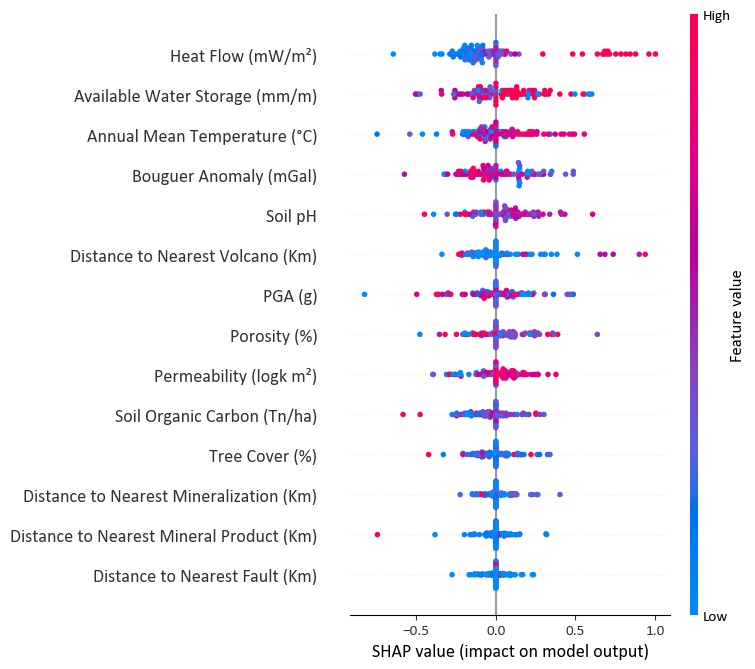

In [48]:
# 3. SHAP Summary using KernelExplainer

if isinstance(X_train, pd.DataFrame):
    X_train_sample = X_train.sample(50, random_state=42)
else:
    X_train_sample = X_train[:50]

if isinstance(X_test, pd.DataFrame):
    X_test_sample = X_val.sample(100, random_state=42)
else:
    X_test_sample = X_val[:100]

# Define the explainer using the model's predict function
explainer = shap.KernelExplainer(best_knn.predict, X_train_sample)

# Compute SHAP values for the test sample
# nsamples controls the number of evaluations to approximate SHAP values
shap_values = explainer.shap_values(X_test_sample, nsamples=100)

# Create SHAP figure and save it
plt.figure()  # Create a new figure before plotting SHAP summary
shap.summary_plot(shap_values, X_test_sample, feature_names=features_preselected, show=False) 

# Save the image before displaying it
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_12b.png", dpi=300, bbox_inches="tight")

# Show the image
plt.show()


## ARBOL DE DECISION

In [49]:
# -----------------------
#  Model: Decision Tree
# -----------------------
print("\n=== Árbol de Decisión ===")
dt = DecisionTreeRegressor(random_state=42)
param_grid_dt = {
    'max_depth': [None, 3, 5, 7, 10, 15, 20], 
    'min_samples_split': [2, 5, 10, 20, 50],   
    'min_samples_leaf': [1, 2, 5, 10]          
}
grid_dt = GridSearchCV(dt, param_grid_dt, scoring='r2', cv=5, n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)
print("Mejores parámetros Árbol de Decisión:", grid_dt.best_params_)
best_dt = grid_dt.best_estimator_


=== Árbol de Decisión ===
Fitting 5 folds for each of 140 candidates, totalling 700 fits
Mejores parámetros Árbol de Decisión: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}


In [50]:
# Evaluation in TEST
y_pred_test = best_dt.predict(X_test)
dt_test_r2 = r2_score(y_test, y_pred_test)
dt_test_mse = mean_squared_error(y_test, y_pred_test)
dt_test_mae = mean_absolute_error(y_test, y_pred_test)

In [51]:
# Evaluation in VALIDATION
y_pred_val = best_dt.predict(X_val)
dt_val_r2 = r2_score(y_val, y_pred_val)
dt_val_mse = mean_squared_error(y_val, y_pred_val)
dt_val_mae = mean_absolute_error(y_val, y_pred_val)

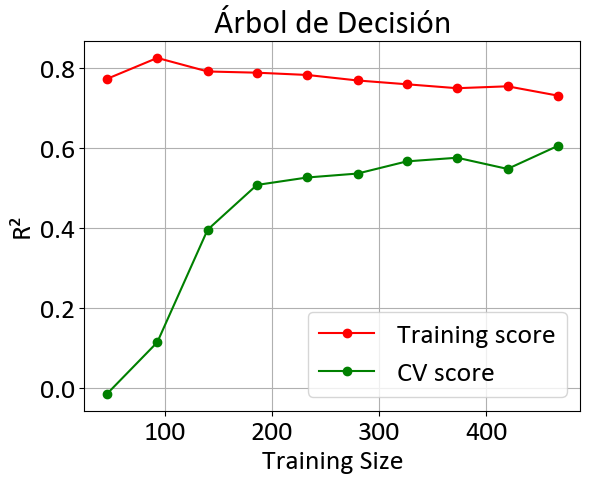

Learning curve saved as: DecisionTreeRegressor_Learning_Curve.png


In [52]:
# Learning curve
plot_learning_curve(best_dt, X_train, y_train, title="Árbol de Decisión")

In [53]:
results.append({
    'Modelo': 'Árbol_Decisión',
    'Test_R2': dt_test_r2,
    'Test_MSE': dt_test_mse,
    'Test_MAE': dt_test_mae,
    'Val_R2': dt_val_r2,
    'Val_MSE': dt_val_mse,
    'Val_MAE': dt_val_mae
})

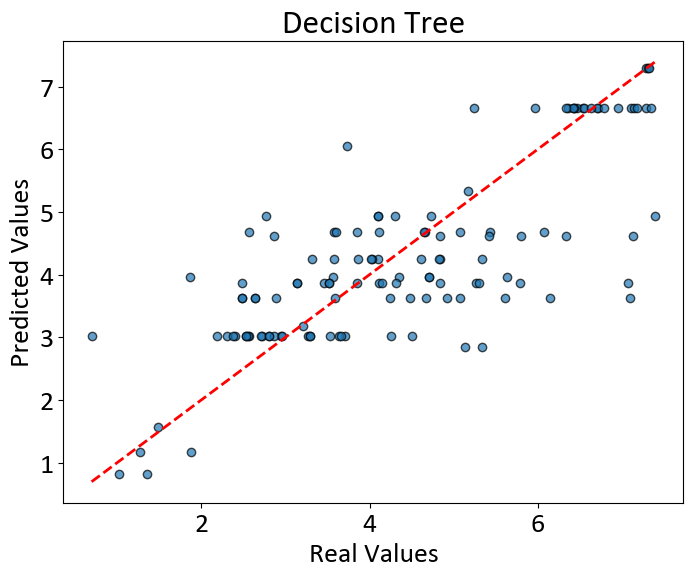

In [54]:
# -------------------------------
# 1. Predicted vs Actual
# -------------------------------
y_pred_test = best_dt.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_val, alpha=0.7, edgecolor='k')
# Ideal reference line (perfect prediction: y = x)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--', lw=2)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("Decision Tree")
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_10c.png", dpi=300, bbox_inches="tight") 
plt.show()

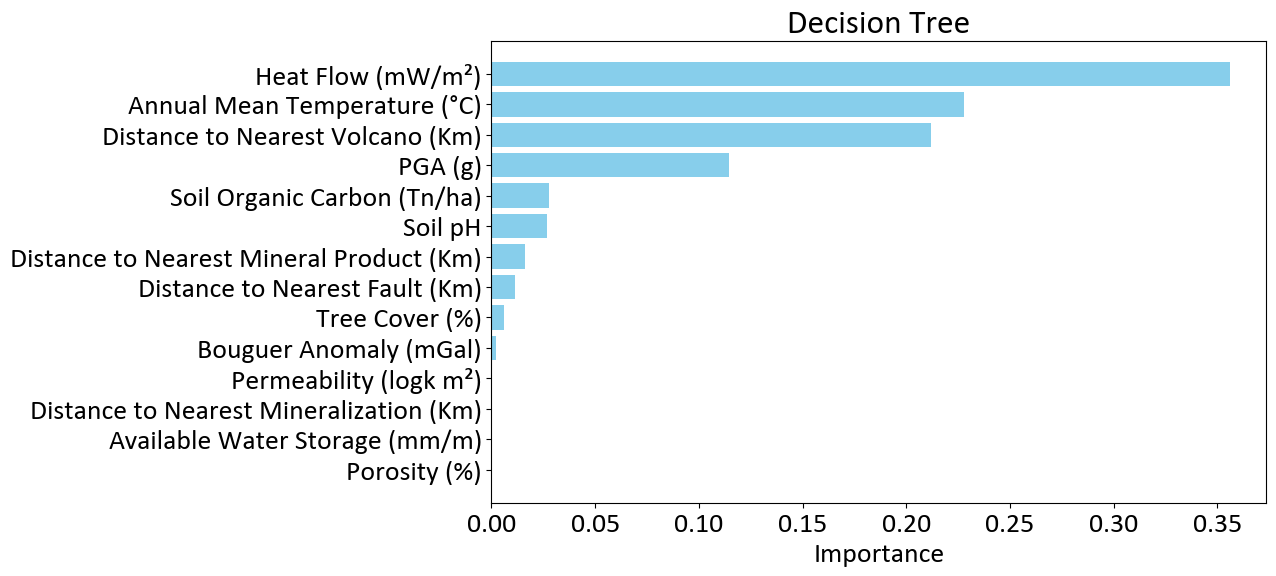

In [55]:
# -------------------------------
# 3. Feature Importance
# -------------------------------

importances = best_dt.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
features_sorted = np.array(features_preselected)[sorted_idx]

plt.figure(figsize=(10,6))
plt.barh(features_sorted, importances[sorted_idx], color="skyblue")
plt.gca().invert_yaxis()  # Ensure the most important feature appears at the top
plt.xlabel("Importance")
plt.title("Decision Tree")
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_11c.png", dpi=300, bbox_inches="tight")  
plt.show()

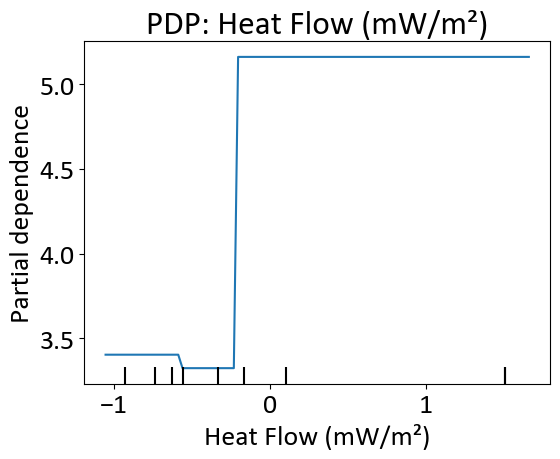

In [56]:
# -------------------------------
# 4. Partial Dependence Plot (PDP) for the most important variable
# -------------------------------

# Select the most important variable
first_feature = features_sorted[0]

fig, ax = plt.subplots(figsize=(6, 5)) 

# Plot the PDP for the most important feature
PartialDependenceDisplay.from_estimator(best_dt, X_train, [first_feature], ax=ax)

ax.set_title(f"PDP: {first_feature}")
plt.tight_layout()
#plt.savefig("DT_Partial_Dependence_FirstFeature.png", dpi=300, bbox_inches="tight")  # Adjusted dpi to 300

# Show the figure
plt.show()

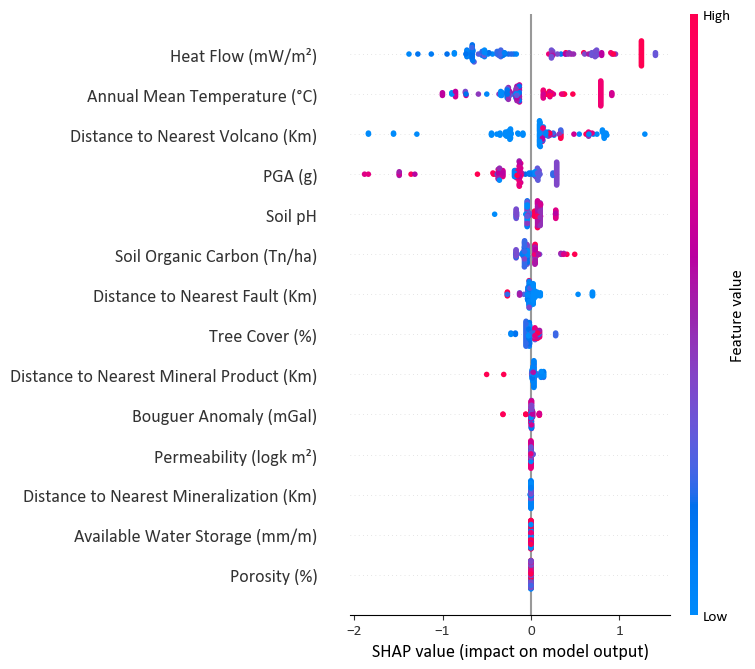

In [57]:
# -------------------------------
# 5. SHAP Summary with TreeExplainer
# -------------------------------

explainer = shap.TreeExplainer(best_dt)
shap_values = explainer.shap_values(X_val)

# Generate SHAP summary
plt.figure()
shap.summary_plot(shap_values, X_val, feature_names=features_preselected, show=False)

# Save the image before displaying it
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_12c.png", dpi=300, bbox_inches="tight") 

# Show the image
plt.show()

## RANDOM FOREST

In [58]:
# -----------------------
# 4. Model: Random Forest
# -----------------------
print("\n=== Random Forest ===")
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400],      
    'max_depth': [None, 5, 10, 15, 20],        
    'min_samples_split': [2, 5, 10],           
    'min_samples_leaf': [1, 2, 4],             
    'bootstrap': [True, False]                 
}
grid_rf = GridSearchCV(rf, param_grid_rf, scoring='r2', cv=5, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)
print("Mejores parámetros Random Forest:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_


=== Random Forest ===
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Mejores parámetros Random Forest: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [59]:
# Evaluation in TEST
y_pred_test = best_rf.predict(X_test)
rf_test_r2 = r2_score(y_test, y_pred_test)
rf_test_mse = mean_squared_error(y_test, y_pred_test)
rf_test_mae = mean_absolute_error(y_test, y_pred_test)

In [60]:
# Evaluation in VALIDATION
y_pred_val = best_rf.predict(X_val)
rf_val_r2 = r2_score(y_val, y_pred_val)
rf_val_mse = mean_squared_error(y_val, y_pred_val)
rf_val_mae = mean_absolute_error(y_val, y_pred_val)

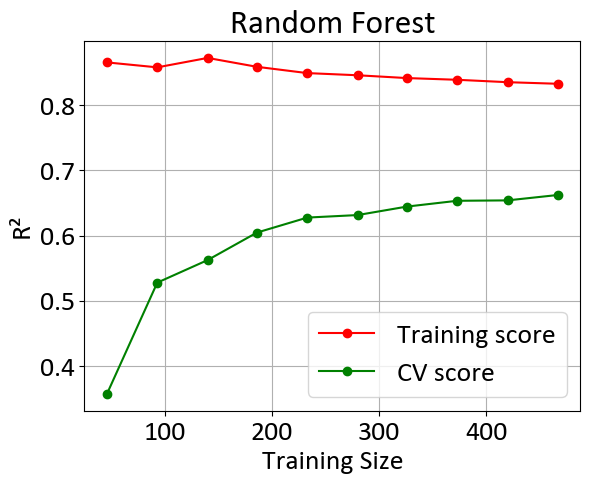

Learning curve saved as: RandomForestRegressor_Learning_Curve.png


In [61]:
# Learning curve
plot_learning_curve(best_rf, X_train, y_train, title="Random Forest")

In [62]:
results.append({
    'Modelo': 'Random_Forest',
    'Test_R2': rf_test_r2,
    'Test_MSE': rf_test_mse,
    'Test_MAE': rf_test_mae,
    'Val_R2': rf_val_r2,
    'Val_MSE': rf_val_mse,
    'Val_MAE': rf_val_mae
})

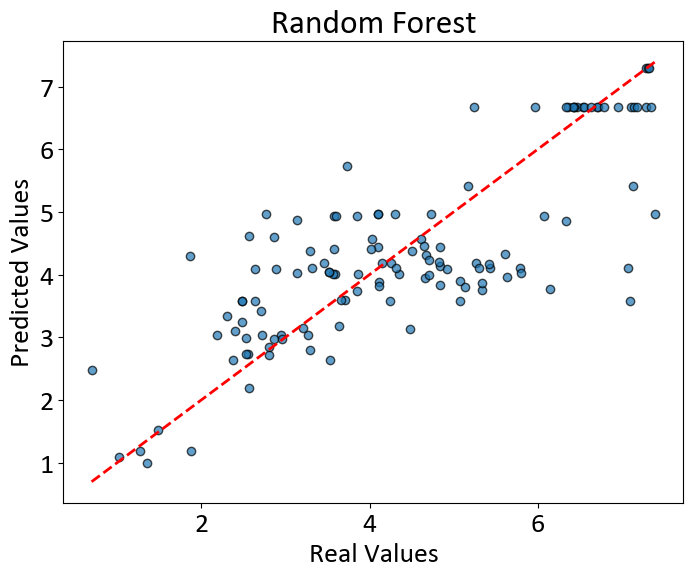

In [63]:
# -------------------------------
# 1. Predicted vs Actual Values
# -------------------------------

y_pred_test = best_rf.predict(X_val)

plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_val, alpha=0.7, edgecolor='k')
# Ideal reference line (where actual values equal predicted values)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--', lw=2)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest")
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_10d.png", dpi=300, bbox_inches="tight") 
plt.show()


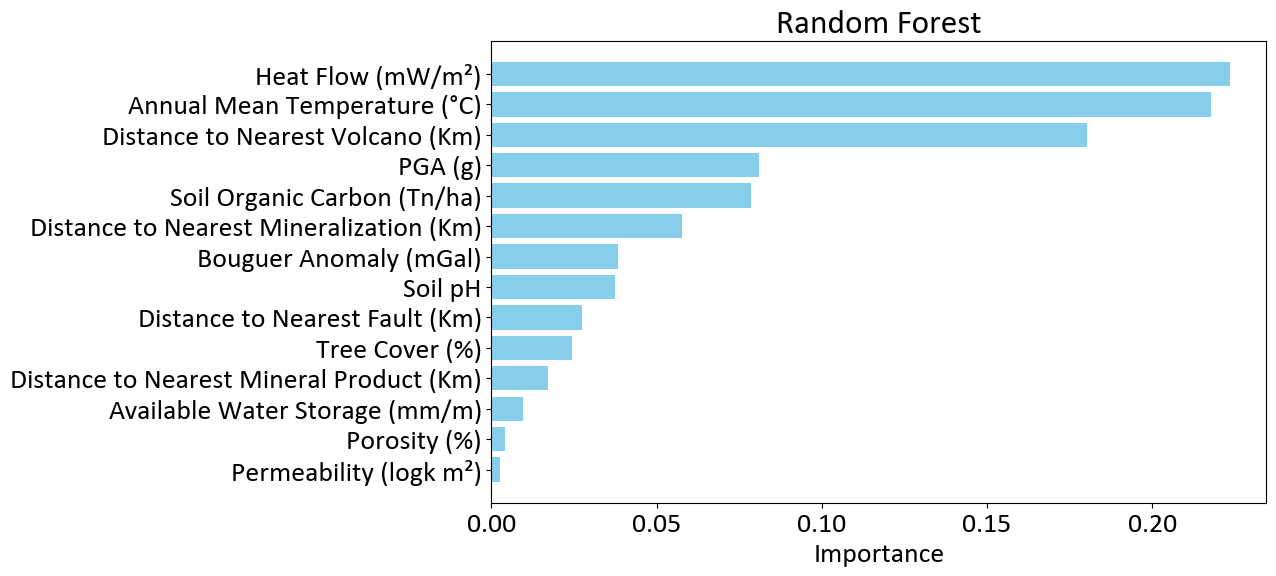

In [64]:
# -------------------------------
# 3. Feature Importance
# -------------------------------

importances = best_rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
features_sorted = np.array(features_preselected)[sorted_idx]

plt.figure(figsize=(10,6))
plt.barh(features_sorted, importances[sorted_idx], color="skyblue")
plt.gca().invert_yaxis()  # The most important feature will appear at the top
plt.xlabel("Importance")
plt.title("Random Forest")
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_11d.png", dpi=300, bbox_inches="tight") 
plt.show()

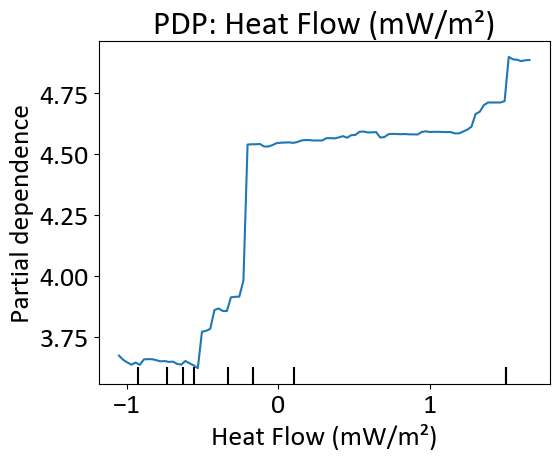

In [65]:
# -------------------------------
# 4. Partial Dependence Plot (PDP) for the most important variable
# -------------------------------

# Select the most important variable
first_feature = features_sorted[0]

fig, ax = plt.subplots(figsize=(6, 5))  
# Plot the PDP for the most important feature
PartialDependenceDisplay.from_estimator(best_rf, X_train, [first_feature], ax=ax)

ax.set_title(f"PDP: {first_feature}")
plt.tight_layout()
#plt.savefig("RF_Partial_Dependence_FirstFeature.png", dpi=300, bbox_inches="tight")  # Adjusted dpi to 300

# Show the figure
plt.show()

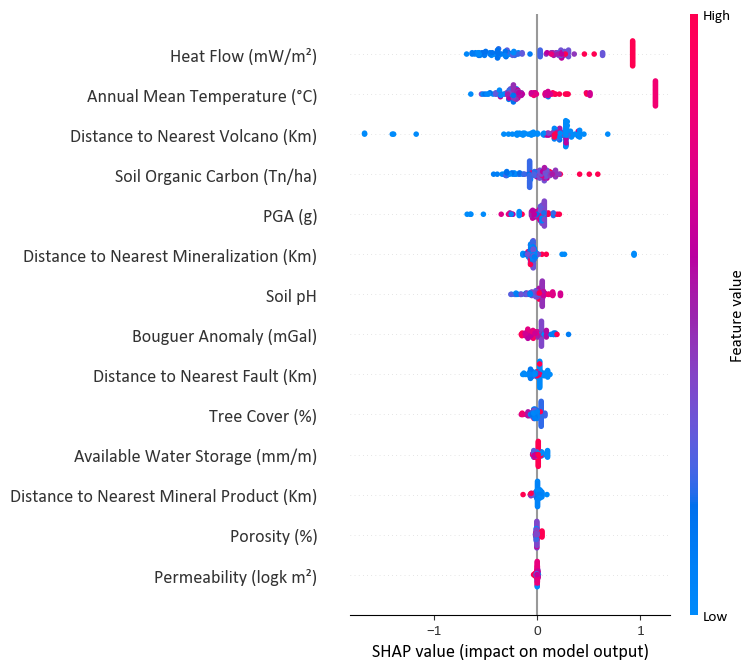

In [66]:
# -------------------------------
# 5. SHAP Summary with TreeExplainer
# -------------------------------
# For tree-based models, TreeExplainer is very efficient
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_val)

plt.figure()  # Create a new figure before plotting the SHAP graph
shap.summary_plot(shap_values, X_val, feature_names=features_preselected, show=False)

# Save the image before displaying it
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_12d.png", dpi=300, bbox_inches="tight")  

# Show the image
plt.show()

## GRADIENT BOOSTING

In [67]:
# -----------------------
# 5. Model: Gradient Boosting (GBM)
# -----------------------
print("\n=== Gradient Boosting ===")
gbm = GradientBoostingRegressor(random_state=42)
param_grid_gbm = {
    'n_estimators': [100, 200, 300, 500], 
    'learning_rate': [0.001, 0.01, 0.1, 0.2],  
    'max_depth': [2, 3, 5, 7],           
    'subsample': [1.0, 0.8, 0.6],         
    'min_samples_split': [2, 5, 10]       
}
grid_gbm = GridSearchCV(gbm, param_grid_gbm, scoring='r2', cv=5, n_jobs=-1, verbose=1)
grid_gbm.fit(X_train, y_train)
print("Mejores parámetros Gradient Boosting:", grid_gbm.best_params_)
best_gbm = grid_gbm.best_estimator_


=== Gradient Boosting ===
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Mejores parámetros Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 0.6}


In [68]:
# Evaluation in TEST
y_pred_test = best_gbm.predict(X_test)
gbm_test_r2 = r2_score(y_test, y_pred_test)
gbm_test_mse = mean_squared_error(y_test, y_pred_test)
gbm_test_mae = mean_absolute_error(y_test, y_pred_test)

# Evaluation in VALIDATION
y_pred_val = best_gbm.predict(X_val)
gbm_val_r2 = r2_score(y_val, y_pred_val)
gbm_val_mse = mean_squared_error(y_val, y_pred_val)
gbm_val_mae = mean_absolute_error(y_val, y_pred_val)

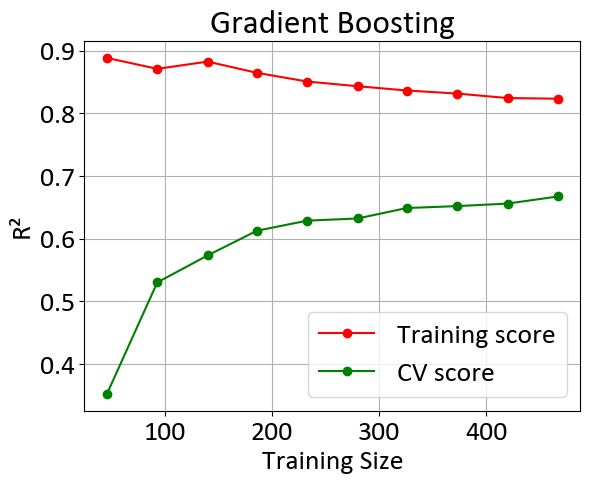

Learning curve saved as: GradientBoostingRegressor_Learning_Curve.png


In [69]:
# Learning curve
plot_learning_curve(best_gbm, X_train, y_train, title="Gradient Boosting")

In [70]:
results.append({
    'Modelo': 'Gradient_Boosting',
    'Test_R2': gbm_test_r2,
    'Test_MSE': gbm_test_mse,
    'Test_MAE': gbm_test_mae,
    'Val_R2': gbm_val_r2,
    'Val_MSE': gbm_val_mse,
    'Val_MAE': gbm_val_mae
})

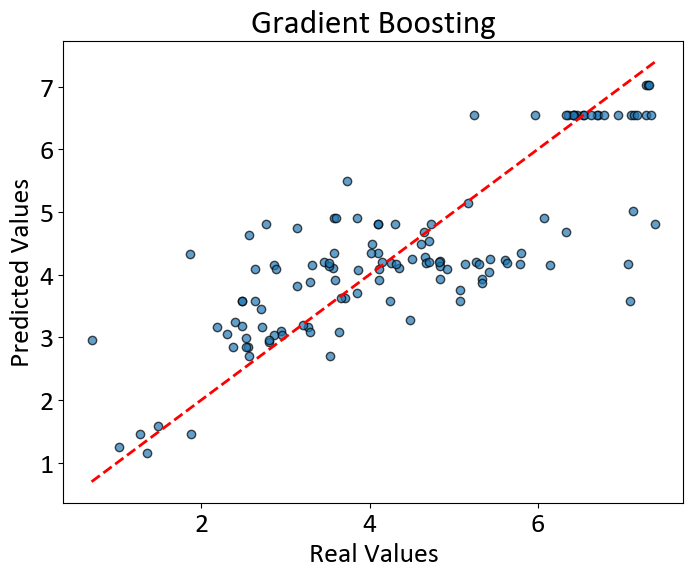

In [71]:
# -------------------------------
# 1. Predicted vs Actual Values
# -------------------------------
y_pred_test = best_gbm.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_val, alpha=0.7, edgecolor='k')
# Ideal reference line (where actual values equal predicted values)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--', lw=2)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("Gradient Boosting")
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_10e.png", dpi=300, bbox_inches="tight")
plt.show()

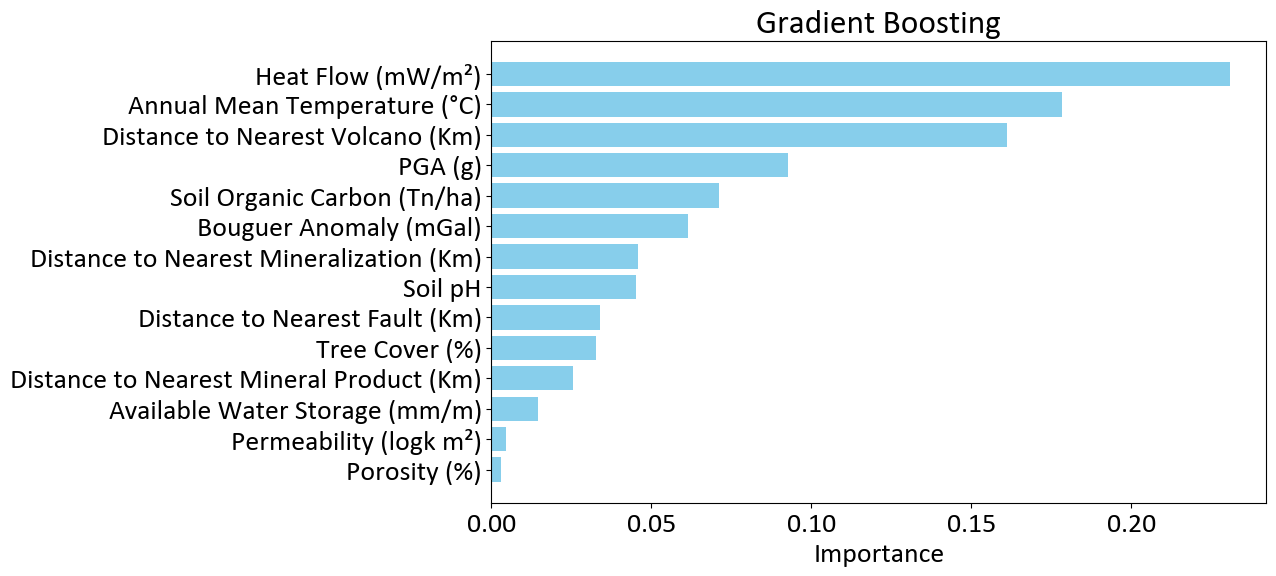

In [72]:
# -------------------------------
# 3. Feature Importance
# -------------------------------

importances = best_gbm.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
features_sorted = np.array(features_preselected)[sorted_idx]

plt.figure(figsize=(10,6))
plt.barh(features_sorted, importances[sorted_idx], color="skyblue")
plt.gca().invert_yaxis()  # The most important feature will appear at the top
plt.xlabel("Importance")
plt.title("Gradient Boosting")
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_11e.png", dpi=300, bbox_inches="tight")
plt.show()

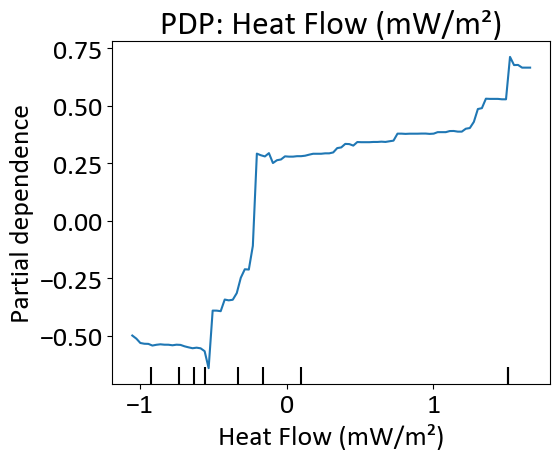

In [73]:
# -------------------------------
# 4. Partial Dependence Plot (PDP) for the most important variable
# -------------------------------

# Select the most important variable
first_feature = features_sorted[0]

fig, ax = plt.subplots(figsize=(6, 5)) 

# Plot the PDP for the most important feature
PartialDependenceDisplay.from_estimator(best_gbm, X_train, [first_feature], ax=ax)

ax.set_title(f"PDP: {first_feature}")
plt.tight_layout()
#plt.savefig("GBM_Partial_Dependence_FirstFeature.png", dpi=300, bbox_inches="tight")  # Adjusted dpi to 300

# Show the figure
plt.show()


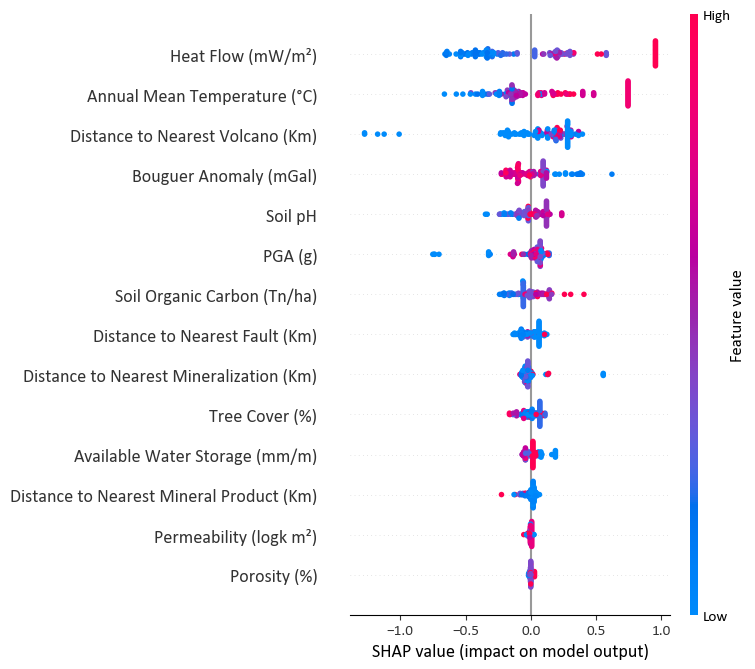

In [74]:
# -------------------------------
# 5. SHAP Summary with TreeExplainer
# -------------------------------
# TreeExplainer is efficient for tree-based models like Gradient Boosting
explainer = shap.TreeExplainer(best_gbm)
shap_values = explainer.shap_values(X_val)

# Generate SHAP summary
plt.figure()
shap.summary_plot(shap_values, X_val, feature_names=features_preselected, show=False)

plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_12e.png", dpi=300, bbox_inches="tight") 

# Show the image
plt.show()

## COMPARACIÓN GRÁFICA

In [78]:
print(type(results))


<class 'list'>


In [82]:
# -*- coding: utf-8 -*-
# Reconversión de métricas a escala real (g·m⁻²·d⁻¹) y actualización de results_df

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# 2️⃣ Inversa del log(y+1)
y_test_real = np.exp(y_test) - 1
y_val_real  = np.exp(y_val)  - 1

# 3️⃣ Diccionario de modelos
modelos = {
    'Gradient_Boosting': best_gbm,
    'Random_Forest':     best_rf,
    'Árbol_Decisión':    best_dt,
    'KNN_Regressor':     best_knn,
    'SVR_Regressor':     best_svr,
}

# 4️⃣ Bucle para recalcular MAE/MSE/RMSE en escala real
for nombre, modelo in modelos.items():
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled  = scaler.transform(X_val)

    y_pred_test_log = modelo.predict(X_test_scaled)
    y_pred_val_log  = modelo.predict(X_val_scaled)

    # Inversa del log(y+1)
    y_pred_test_real = np.exp(y_pred_test_log) - 1
    y_pred_val_real  = np.exp(y_pred_val_log)  - 1

    # Métricas con unidades reales
    test_mae = mean_absolute_error(y_test_real, y_pred_test_real)
    test_mse = mean_squared_error(y_test_real, y_pred_test_real)
    val_mae  = mean_absolute_error(y_val_real,  y_pred_val_real)
    val_mse  = mean_squared_error(y_val_real,  y_pred_val_real)

    # Actualizar resultados
    if nombre in results_df.index:
        results_df.loc[nombre, 'Test_MAE'] = test_mae
        results_df.loc[nombre, 'Test_MSE'] = test_mse
        results_df.loc[nombre, 'Val_MAE']  = val_mae
        results_df.loc[nombre, 'Val_MSE']  = val_mse
        results_df.loc[nombre, 'Test_RMSE'] = np.sqrt(test_mse)
        results_df.loc[nombre, 'Val_RMSE']  = np.sqrt(val_mse)
    else:
        print(f"[Aviso] '{nombre}' no está en results_df.index; omito actualización.")

# 5️⃣ Mostrar tabla final
results_df = results_df.apply(pd.to_numeric, errors='ignore').round(3)
display(results_df)



,Test_R2,Test_MSE,Test_MAE,Val_R2,Val_MSE,Val_MAE,Test_RMSE,Val_RMSE
Modelo,,,,,,,,
SVR_Regressor,0.624,148856.862,177.802,0.639,241185.682,257.067,385.820,491.107
KNN_Regressor,0.638,160158.149,220.600,0.569,243177.987,276.638,400.198,493.131
Árbol_Decisión,0.613,155126.561,187.478,0.591,251228.942,269.062,393.861,501.227
Random_Forest,0.680,154684.599,184.213,0.626,250115.885,265.595,393.300,500.116
Gradient_Boosting,0.688,152208.257,182.108,0.644,247128.752,263.511,390.139,497.120


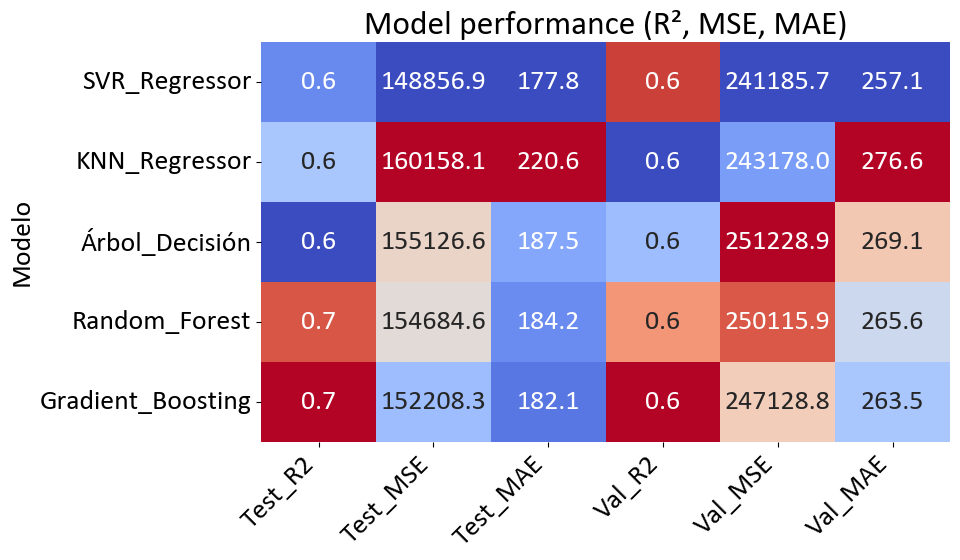

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Normalización por columna (solo para color)
df_norm = results_df[['Test_R2','Test_MSE','Test_MAE','Val_R2','Val_MSE','Val_MAE']].copy()
df_norm = (df_norm - df_norm.min()) / (df_norm.max() - df_norm.min())

# Crear heatmap con colores normalizados, pero anotando valores reales
plt.figure(figsize=(10,6))
sns.heatmap(df_norm, annot=results_df[['Test_R2','Test_MSE','Test_MAE','Val_R2','Val_MSE','Val_MAE']].round(1),
            fmt="", cmap="coolwarm", cbar=False)
plt.title("Model performance (R², MSE, MAE)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_9a.png", dpi=300)
plt.show()


# Stacking Regressor

In [84]:
# --- Define the base models with more diversity ---
estimators = [
    ('svr', best_svr),         
    ('knn', best_knn),
    ('dt', best_dt),
    ('rf', best_rf),           
    ('gbm', best_gbm),         
    ('ridge', Ridge(alpha=1.0))  # Linear model for greater diversity
]

# --- Define the non-linear meta-stimulator ---
meta_estimator = XGBRegressor(objective='reg:squarederror', random_state=42)

# --- Create the Stacking Regressor with passthrough activated ---
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_estimator,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# --- Defining the search space for the meta-estimator ---
# We use the notation “final_estimator__” to set the hyperparameters of the meta-estimator
param_distributions = {
    'final_estimator__n_estimators': randint(50, 300),
    'final_estimator__max_depth': randint(3, 10),
    'final_estimator__learning_rate': uniform(0.01, 0.2),
    'final_estimator__subsample': uniform(0.6, 0.4)  # valores entre 0.6 y 1.0
}

# --- Perform search with RandomizedSearchCV ---
random_search = RandomizedSearchCV(
    estimator=stacking_model,
    param_distributions=param_distributions,
    n_iter=40,          
    scoring='r2',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

print("Best parameters found in the Stacking Regressor:")
print(random_search.best_params_)

# Extracting the best stacking model
best_stacking = random_search.best_estimator_

# --- Evaluation of the robust stacking model (in real units) ---

# Inverse transform of the target and predictions (undo log1p)
y_test_real = np.expm1(y_test)
y_val_real  = np.expm1(y_val)

y_pred_test_log = best_stacking.predict(X_test)
y_pred_val_log  = best_stacking.predict(X_val)

y_pred_test_real = np.expm1(y_pred_test_log)
y_pred_val_real  = np.expm1(y_pred_val_log)

# --- Evaluation in TEST (real units) ---
stack_r2_test  = r2_score(y_test_real, y_pred_test_real)
stack_mse_test = mean_squared_error(y_test_real, y_pred_test_real)
stack_mae_test = mean_absolute_error(y_test_real, y_pred_test_real)
stack_rmse_test = np.sqrt(stack_mse_test)

print("\nStacking Regressor - Metrics in Test (real units):")
print("R²:", round(stack_r2_test, 3))
print("MSE:", round(stack_mse_test, 3))
print("MAE:", round(stack_mae_test, 3))
print("RMSE:", round(stack_rmse_test, 3))

# --- Evaluation in VALIDATION (real units) ---
stack_r2_val  = r2_score(y_val_real, y_pred_val_real)
stack_mse_val = mean_squared_error(y_val_real, y_pred_val_real)
stack_mae_val = mean_absolute_error(y_val_real, y_pred_val_real)
stack_rmse_val = np.sqrt(stack_mse_val)

print("\nStacking Regressor - Metrics in Validation (real units):")
print("R²:", round(stack_r2_val, 3))
print("MSE:", round(stack_mse_val, 3))
print("MAE:", round(stack_mae_val, 3))
print("RMSE:", round(stack_rmse_val, 3))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found in the Stacking Regressor:
{'final_estimator__learning_rate': np.float64(0.019333132642723086), 'final_estimator__max_depth': 6, 'final_estimator__n_estimators': 257, 'final_estimator__subsample': np.float64(0.6931085361721216)}

Stacking Regressor - Metrics in Test (real units):
R²: 0.693
MSE: 37534.054
MAE: 90.296
RMSE: 193.737

Stacking Regressor - Metrics in Validation (real units):
R²: 0.552
MSE: 80861.838
MAE: 145.348
RMSE: 284.362



Stacking Regressor Metrics Summary:
             Test    Validation
R²       0.692504      0.551970
MSE  37534.054500  80861.837755
MAE     90.295655    145.348413


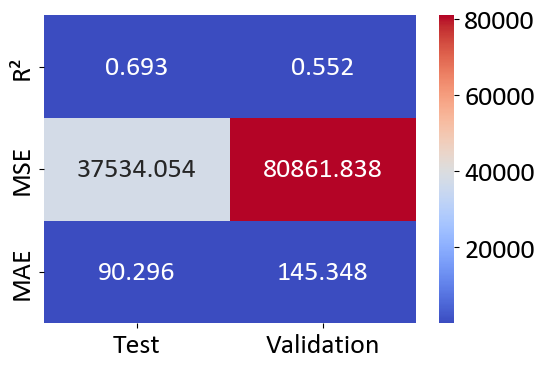

In [85]:
# Create a dictionary with evaluation metrics
metrics_data = {
    "Test": {
        "R²": stack_r2_test,
        "MSE": stack_mse_test,
        "MAE": stack_mae_test
    },
    "Validation": {
        "R²": stack_r2_val,
        "MSE": stack_mse_val,
        "MAE": stack_mae_val
    }
}

# Convert the dictionary into a DataFrame
df_metrics = pd.DataFrame(metrics_data)

# Display the metrics DataFrame
print("\nStacking Regressor Metrics Summary:")
print(df_metrics)

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_metrics, annot=True, fmt=".3f", cmap="coolwarm")
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_9b.png", dpi=300, bbox_inches="tight")  # Adjusted dpi to 300
plt.show()


In [86]:
# We reverse the logarithmic transformation 
y_pred_test_orig = np.exp(y_pred_val) - 1
y_test_orig = np.exp(y_val) - 1

# Recalculate metrics in the original scale (gm-2d-1)
mse_orig = mean_squared_error(y_test_orig, y_pred_test_orig)
mae_orig = mean_absolute_error(y_test_orig, y_pred_test_orig)

print("MSE in original Test units (gm-2d-1):", mse_orig)
print("MAE in original Test units (gm-2d-1):", mae_orig)

MSE in original Test units (gm-2d-1): 83915.97871677043
MAE in original Test units (gm-2d-1): 138.88869401140255


In [87]:
# Supongamos que y_pred_test son las predicciones en escala logarítmica y y_test son los valores reales (log transformados)
y_pred_test_orig = np.exp(y_pred_val) - 1
y_test_orig = np.exp(y_val) - 1

# Recalcular las métricas en la escala original (gm-2d-1)
mse_orig = mean_squared_error(y_test_orig, y_pred_test_orig)
mae_orig = mean_absolute_error(y_test_orig, y_pred_test_orig)

print("MSE in original Validation units (gm-2d-1):", mse_orig)
print("MAE in original Validation (gm-2d-1):", mae_orig)

MSE in original Validation units (gm-2d-1): 83915.97871677043
MAE in original Validation (gm-2d-1): 138.88869401140255


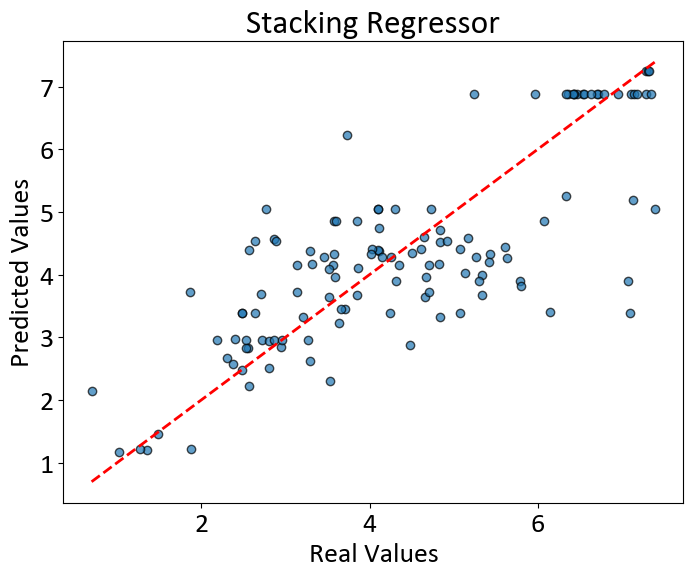

In [88]:
# Predicted vs Actual
y_pred_test_stack = best_stacking.predict(X_val)
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_val_log, alpha=0.7, edgecolor='k')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--', lw=2)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("Stacking Regressor")
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_10f.png", dpi=300, bbox_inches="tight") 
plt.show()

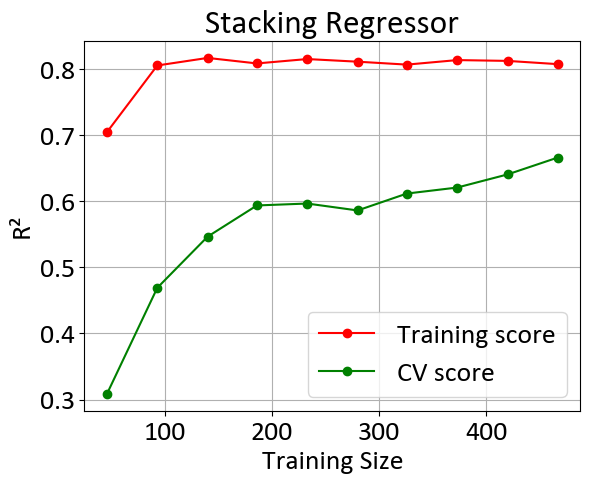

Learning curve saved as: StackingRegressor_Learning_Curve.png


In [89]:
plot_learning_curve(best_stacking, X_train, y_train, title="Stacking Regressor")

### Importancia de Características del Meta-Estimador

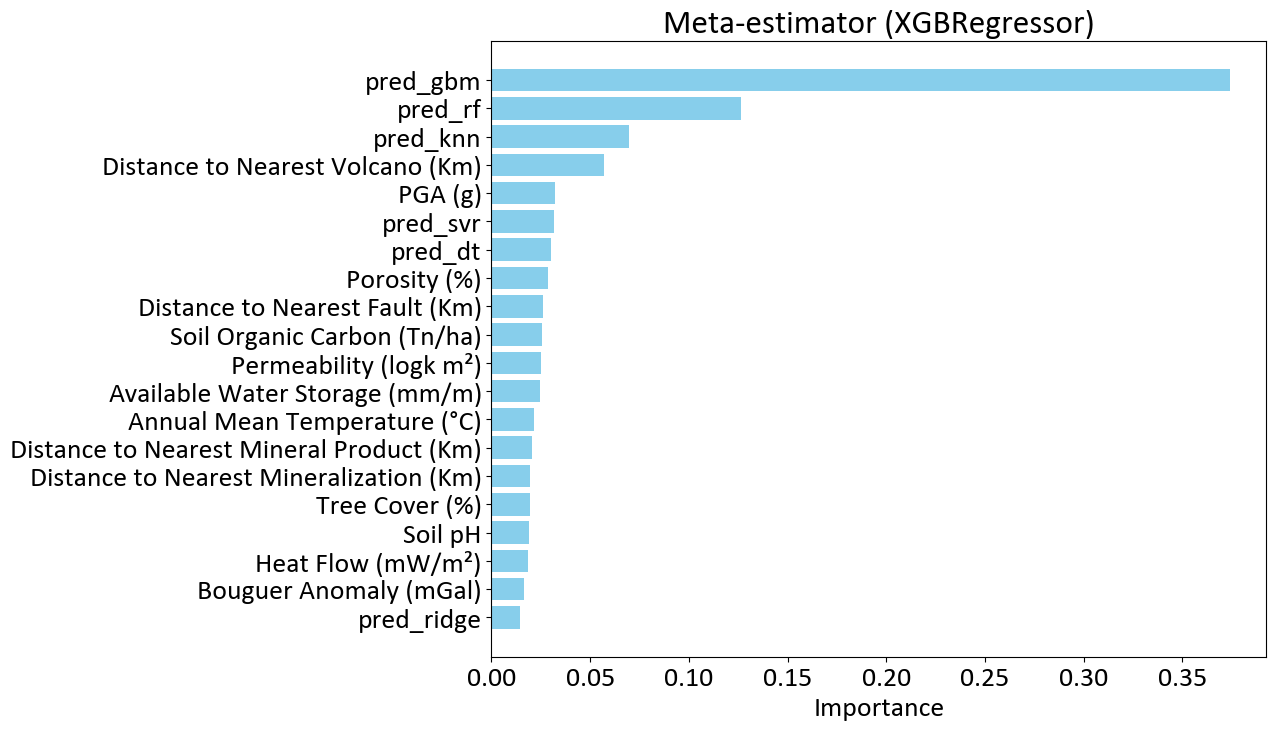

In [90]:
# Build names for the meta-estimator features
# First: the predictions of each base model
meta_base_names = [f"pred_{name}" for name, _ in estimators]
# Then: the original features (passthrough)
meta_feature_names = meta_base_names + features_preselected

# Extract feature importances from the meta-estimator
meta_importances = best_stacking.final_estimator_.feature_importances_
sorted_idx = np.argsort(meta_importances)[::-1]

plt.figure(figsize=(10,8))
plt.barh(np.array(meta_feature_names)[sorted_idx], meta_importances[sorted_idx], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Meta-estimator (XGBRegressor)")
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_11f.png", dpi=300, bbox_inches="tight") 
plt.show()

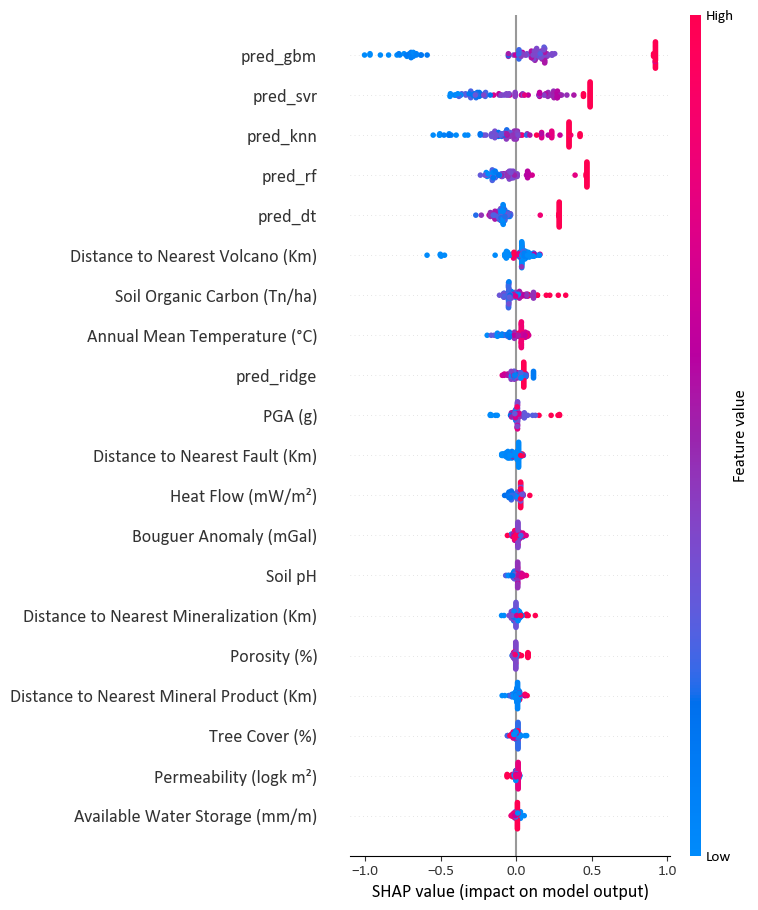

In [91]:
import shap

# Get the meta-features matrix from the test set
meta_features = best_stacking.transform(X_val)

# Create a TreeExplainer for the meta-estimator
explainer_meta = shap.TreeExplainer(best_stacking.final_estimator_)
shap_values_meta = explainer_meta.shap_values(meta_features)

# Generate SHAP summary using the defined feature names
plt.figure()
shap.summary_plot(shap_values_meta, meta_features, feature_names=meta_feature_names, show=False)

# Save the image before displaying it
plt.savefig(r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\03_Figures/figure_12f.png", dpi=300, bbox_inches="tight")  # Adjusted dpi to 300

# Show the image
plt.show()

## **Mask - Model Applicability Limit**

In this section, we define a spatial “applicability mask” that restricts the final CO₂ flux predictions to areas where the machine-learning model is scientifically meaningful. Since the training data is concentrated near active faults and regions with measurable seismic hazard, we build a mask that identifies grid cells located within 40 km of an active fault or with PGA values above 0.10 g. These two criteria capture tectonically active environments that resemble the conditions represented in the degassing database. We load the harmonized rasters for distance to faults and PGA, apply the thresholds, and combine them into a binary mask that assigns 1 to valid prediction zones and 0 elsewhere. This mask ensures that the global prediction map avoids extrapolation into geological settings for which the model has no training support.

In [92]:
BASE = r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling"
PROCESSED = os.path.join(BASE, "01_Data_Global", "Processed")
NODATA = -9999.0

# Mask entries 
path_faults = os.path.join(PROCESSED, "ActiveFaults_distance_km_0p10deg_WGS84.tif")
path_pga    = os.path.join(PROCESSED, "PGA_0p10deg_WGS84.tif")

# Thresholds
D_FAULT_KM = 40   # maximum distance to faults (km)
PGA_G      = 0.10    # minimum acceleration (g)

# Auxiliary function for clean reading
def read_clean(path):
    with rasterio.open(path) as ds:
        arr = ds.read(1).astype("float32")
        nod = ds.nodata if ds.nodata is not None else NODATA
        arr = np.where(arr == nod, np.nan, arr)
        return arr, ds.meta.copy()

# Load data
faults_km, meta_faults = read_clean(path_faults)
pga_g, meta_pga = read_clean(path_pga)

# We use PGA metadata as a reference.
meta = meta_pga
meta.update(dtype="uint8", count=1, nodata=0, compress="LZW", tiled=True)

# Conditions and mask
cond_fault = faults_km <= D_FAULT_KM
cond_pga   = pga_g     >= PGA_G
mask = (cond_fault | cond_pga)

# Where both are NaN → 0 (masked)
mask = np.where(np.isnan(faults_km) & np.isnan(pga_g), 0, mask).astype("uint8")

# Save mask 
mask_tif = os.path.join(PROCESSED, "Mask_FaultsOrPGA_0p10deg_WGS84.tif")
with rasterio.open(mask_tif, "w", **meta) as dst:
    dst.write(mask, 1)

print("Mask stored:", mask_tif)

Mask stored: E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\01_Data_Global\Processed\Mask_FaultsOrPGA_0p10deg_WGS84.tif


## **GLOBAL PREDICTION (Pixel x Pixel)**


In this final stage, we apply the trained stacking model to generate a global prediction map of diffuse CO₂ degassing at 0.10° resolution. The procedure operates directly on raster blocks to efficiently process the entire planet while minimizing memory usage. For each grid window, we read the harmonized predictor rasters, apply the same feature transformations used during model training (including inverse-distance conversions, porosity scaling, and median imputation), and standardize the values using the original training scaler. Predictions are computed only for pixels within the previously defined applicability mask and inside continental boundaries, ensuring that the model is applied exclusively in regions with geological conditions similar to the training data. The predicted values, converted back from log-space to physical flux units, are written incrementally to a new GeoTIFF file. This block-wise workflow produces a consistent, scalable, and fully reproducible global CO₂ emission map derived from the machine-learning model.

In [93]:

#  Paths and constants 
BASE = r"E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling"
PROCESSED = os.path.join(BASE, "01_Data_Global", "Processed")
MASK_PATH = os.path.join(PROCESSED, "Mask_FaultsOrPGA_0p10deg_WGS84.tif")
OUT_RASTER = os.path.join(PROCESSED, "Prediccion_ML_CO2_MASKED_ONLY_0p10deg_WGS84.tif")

# Continent shapefile route
DATA = Path(BASE) / "01_Data_Global"
CONTINENTS_SHP = DATA / "Continents World" / "CONTINENTES MUNDO LIMITE BORDE geogpsperu suyopomalia.shp"

NODATA = -9999.0
SMALL  = 1e-3        # avoid division by 0 in distances
TILE   = 512         # window size (sub-blocks)

#  Mapping: feature-name (as in training) -> GeoTIFF
feature_to_file = {
    'Bouguer Anomaly (mGal)':                  os.path.join(PROCESSED, "BouguerAnomaly_0p10deg_WGS84.tif"),
    'Heat Flow (mW/m²)':                       os.path.join(PROCESSED, "HeatFlow_0p10deg_WGS84.tif"),
    'Annual Mean Temperature (°C)':            os.path.join(PROCESSED, "MeanAnnualSoilTemp_0p10deg_WGS84.tif"),
    'Soil Organic Carbon (Tn/ha)':             os.path.join(PROCESSED, "SoilOrganicCarbon_0p10deg_WGS84.tif"),
    'Soil pH':                                 os.path.join(PROCESSED, "Soil_pH_0p10deg_WGS84.tif"),
    'Distance to Nearest Fault (Km)':          os.path.join(PROCESSED, "ActiveFaults_distance_km_0p10deg_WGS84.tif"),
    'Distance to Nearest Mineralization (Km)': os.path.join(PROCESSED, "Mineralizations_distance_km_0p10deg_WGS84.tif"),
    'Distance to Nearest Volcano (Km)':        os.path.join(PROCESSED, "Volcanoes_distance_km_0p10deg_WGS84.tif"),
    'Distance to Nearest Mineral Product (Km)':os.path.join(PROCESSED, "MineralCommodity_distance_km_0p10deg_WGS84.tif"),
    'Available Water Storage (mm/m)':          os.path.join(PROCESSED, "AvailableWaterStorage_0p10deg_WGS84.tif"),
    'Tree Cover (%)':                          os.path.join(PROCESSED, "TreeCover_0p10deg_WGS84.tif"),
    'Porosity (%)':                            os.path.join(PROCESSED, "GLHYMPS_Porosity_0p10deg_WGS84.tif"),
    'Permeability (logk m²)':                  os.path.join(PROCESSED, "GLHYMPS_Permeability_0p10deg_WGS84.tif"),
    'PGA (g)':                                 os.path.join(PROCESSED, "PGA_0p10deg_WGS84.tif"),
    # If they do not exist, they are filled with 0:
    'Carbon Dioxide at 1000 hPa (kg kg⁻¹)':    os.path.join(PROCESSED, "CO2_1000hPa_0p10deg_WGS84.tif"),
    'Mean Column Molar Fraction of CO2 (ppm)': os.path.join(PROCESSED, "CO2_Column_0p10deg_WGS84.tif"),
}

# EXACT order of features as in model training
expected_features = [
    'Bouguer Anomaly (mGal)',
    'Heat Flow (mW/m²)',
    'Annual Mean Temperature (°C)',
    'Soil Organic Carbon (Tn/ha)',
    'Soil pH',
    'Distance to Nearest Fault (Km)',
    'Distance to Nearest Mineralization (Km)',
    'Distance to Nearest Volcano (Km)',
    'Distance to Nearest Mineral Product (Km)',
    'Available Water Storage (mm/m)',
    'Tree Cover (%)',
    'Porosity (%)',
    'Permeability (logk m²)',
    'PGA (g)'
]

# cuts ONLY the trained features (and preserves the order):
feature_to_file = {k: feature_to_file.get(k, None) for k in expected_features}

# Preliminary checks 
assert 'best_stacking' in globals(), "The trained 'best_stacking' object is missing.."
assert 'scaler' in globals(), "The 'scaler' object used in training is missing.."
assert getattr(best_stacking, 'passthrough', False), "Stacking should be trained with passthrough=True."
assert all(f in feature_to_file for f in expected_features), "There are features of route-free training in 'feature_to_file'."

# Utilities
def _open_or_none(path):
    """Returns raster dataset or None if the file does not exist."""
    return rasterio.open(path) if (path and os.path.exists(path)) else None

def _read_block(ds, win, nodata_default=NODATA):
    """Read window and convert NODATA->NaN."""
    arr = ds.read(1, window=win).astype("float32")
    nd = ds.nodata if ds.nodata is not None else nodata_default
    return np.where(arr == nd, np.nan, arr)

def _prep_block(block_dict, mask_win_bool):
    """
    block_dict: {feature -> np.array(h,w) or None}
    mask_win_bool: Boolean (h,w) with True in pixels where to predict
    Returns X_scaled (n_sel, n_features) and linear indices (idx) of True pixels.
    """
    h, w = mask_win_bool.shape
    idx = np.flatnonzero(mask_win_bool.ravel())
    n = idx.size
    X = np.zeros((n, len(expected_features)), dtype="float32")

    for j, feat in enumerate(expected_features):
        band = block_dict.get(feat, None)

        if band is None:
            # missing feature -> vector of zeros
            vec = np.zeros(n, dtype="float32")
        else:
            b = band.copy()

            # Specific transformations:
            if feat in ['Distance to Nearest Fault (Km)',
                        'Distance to Nearest Mineralization (Km)',
                        'Distance to Nearest Volcano (Km)',
                        'Distance to Nearest Mineral Product (Km)']:
                # 1) avoid 0; 2) 1/d^2
                b = np.where(np.isnan(b), np.nan, np.where(b <= 0, SMALL, b))
                b = 1.0 / (b ** 2)

            if feat == 'Porosity (%)':
                # comes in fractions (0–1) -> percentage
                flat = b[np.isfinite(b)]
                if flat.size > 0 and np.nanpercentile(flat, 99) <= 1.05:
                    b = b * 100.0

            # Local imputation (median over mask pixels)
            sub = b.ravel()[idx]
            if np.isnan(sub).any():
                med = np.nanmedian(sub)
                if np.isnan(med):
                    med = 0.0
                sub = np.where(np.isnan(sub), med, sub)
            vec = sub.astype("float32")

        X[:, j] = vec

    # Scaling with the training scaler
    Xs = scaler.transform(X)
    return Xs, idx

# Opening datasets

#1) Open the mask ONLY once.
mask_src = rasterio.open(MASK_PATH)
H, W = mask_src.height, mask_src.width
transform, crs = mask_src.transform, mask_src.crs

#2) Template for metadata (e.g., Bouguer)
tpl_path = feature_to_file['Bouguer Anomaly (mGal)']
with rasterio.open(tpl_path) as tpl:
    meta_out = tpl.meta.copy()

#3) Feature readers
readers = {feat: _open_or_none(path) for feat, path in feature_to_file.items()}

# NEW: rasterized continental mask to grid
continents_mask = None
if CONTINENTS_SHP.exists():
    try:
        cont = gpd.read_file(CONTINENTS_SHP)
        geoms = [geom for geom in cont.geometry if geom is not None and not geom.is_empty]
    except Exception as e:
        try:
            import fiona
            from shapely.geometry import shape as shp_shape
            geoms = []
            with fiona.open(str(CONTINENTS_SHP)) as src:
                for feat in src:
                    geom = shp_shape(feat["geometry"])
                    if geom and not geom.is_empty:
                        geoms.append(geom)
        except Exception as e2:
            geoms = []
            print(f"The continent shapefile could not be read.: {e} / {e2}")

    if len(geoms) > 0:
        continents_mask = rasterize(
            [(geom, 1) for geom in geoms],
            out_shape=(H, W),
            transform=transform,
            fill=0,
            dtype="uint8"
        )
        print("Continental mask created.")
    else:
        print("Shapefile of continents without valid geometries; continental clip ignored.")
else:
    print(f"The continent shapefile was not found.: {CONTINENTS_SHP}")

# 4) Output path: if it exists, create it with a timestamp suffix
out_path = OUT_RASTER
if os.path.exists(out_path):
    base, ext = os.path.splitext(out_path)
    out_path = f"{base}_{datetime.now().strftime('%Y%m%d_%H%M%S')}{ext}"
print("→ Writing to:", out_path)

# Writing (loop through windows ONLY where there is a mask)
meta_out.update(driver="GTiff", count=1, dtype="float32", nodata=NODATA, compress="LZW", tiled=True)
with rasterio.open(out_path, "w", **meta_out) as dst:
    for row_off in range(0, H, TILE):
        rows = min(TILE, H - row_off)
        for col_off in range(0, W, TILE):
            cols = min(TILE, W - col_off)
            win = Window(col_off, row_off, cols, rows)

            # Read mask for this window
            m = mask_src.read(1, window=win)
            mask_win_bool = (m == 1)

            # NEW: apply continental trim 
            if continents_mask is not None:
                cm_win = continents_mask[row_off:row_off + rows, col_off:col_off + cols] == 1
                mask_win_bool &= cm_win

            if not mask_win_bool.any():
                # If there are no active pixels, write NODATA and continue.
                dst.write(np.full((rows, cols), NODATA, dtype="float32"), 1, window=win)
                continue

            # Read feature blocks
            block = {feat: (_read_block(r, win) if r is not None else None)
                     for feat, r in readers.items()}

            # Prepare matrix and predict ONLY True pixels
            Xs, idx = _prep_block(block, mask_win_bool)
            y_log = best_stacking.predict(Xs)
            y = np.expm1(y_log).astype("float32")  # inverse of log1p

            # Build output block
            out_block = np.full((rows, cols), NODATA, dtype="float32")
            out_block.ravel()[idx] = y

            # Write block
            dst.write(out_block, 1, window=win)

print("Prediction ONLY in mask written in:", out_path)

# Clean closure of resources
for r in readers.values():
    if r is not None:
        r.close()
mask_src.close()


Continental mask created.
→ Writing to: E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\01_Data_Global\Processed\Prediccion_ML_CO2_MASKED_ONLY_0p10deg_WGS84_20251114_091035.tif
Prediction ONLY in mask written in: E:\Documentos\Universidad Nacional de Colombia\Tesis Pregrado\REVISTA\Corrección\CO2_Flux_Analysis_and_Modeling\01_Data_Global\Processed\Prediccion_ML_CO2_MASKED_ONLY_0p10deg_WGS84_20251114_091035.tif
